### Imports

In [2]:
import seaborn as sns
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import sklearn as sk
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### Conection

In [3]:
with requests.Session() as session:
    URL = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv'
    request = session.get(URL)
    if request.status_code == 200:
        ikea = pd.read_csv(URL).drop_duplicates()
        print('file downloaded')

    else:
        print(f'No data: {request.status_code}')

file downloaded


### EDA

In [4]:
# Загальна розмірність набору даних
ikea.shape

(3694, 14)

In [5]:
# Перші 10 рядків набору даних
ikea.head(10)

,Unnamed: 0,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
0,0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0
1,1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0
2,2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN
3,3,80155205,STIG,Bar furniture,69.0,No old price,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0
4,4,30180504,NORBERG,Bar furniture,225.0,No old price,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0
5,5,10122647,INGOLF,Bar furniture,345.0,No old price,True,https://www.ikea.com/sa/en/p/ingolf-bar-stool-...,No,"Bar stool with backrest, 63 cm",Carina Bengs,45.0,91.0,40.0
6,6,70404875,FRANKLIN,Bar furniture,129.0,No old price,True,https://www.ikea.com/sa/en/p/franklin-bar-stoo...,No,"Bar stool with backrest, foldable, ...",K Hagberg/M Hagberg,44.0,95.0,50.0
7,7,60155602,DALFRED,Bar furniture,195.0,No old price,True,https://www.ikea.com/sa/en/p/dalfred-bar-stool...,No,"Bar stool, 63-74 cm",Sarah Fager,50.0,NaN,50.0
8,8,50406465,FRANKLIN,Bar furniture,129.0,No old price,True,https://www.ikea.com/sa/en/p/franklin-bar-stoo...,No,"Bar stool with backrest, foldable, ...",K Hagberg/M Hagberg,44.0,95.0,50.0
9,9,69304221,EKEDALEN / EKEDALEN,Bar furniture,2176.0,"SR 2,375",True,https://www.ikea.com/sa/en/p/ekedalen-ekedalen...,No,Bar table and 4 bar stools,Ehlén Johansson,NaN,NaN,NaN


In [6]:
# Назви стовпців та їх тип даних
ikea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694 entries, 0 to 3693
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3694 non-null   int64  
 1   item_id            3694 non-null   int64  
 2   name               3694 non-null   object 
 3   category           3694 non-null   object 
 4   price              3694 non-null   float64
 5   old_price          3694 non-null   object 
 6   sellable_online    3694 non-null   bool   
 7   link               3694 non-null   object 
 8   other_colors       3694 non-null   object 
 9   short_description  3694 non-null   object 
 10  designer           3694 non-null   object 
 11  depth              2231 non-null   float64
 12  height             2706 non-null   float64
 13  width              3105 non-null   float64
dtypes: bool(1), float64(4), int64(2), object(7)
memory usage: 378.9+ KB


> З опису на сайті за посиланням випливає, що стовпець price це ціна в саудівських ріялах, стовпці depth, width, height це розміри в сантиметрах

In [7]:
# Базова статистична інформація
ikea.describe()

,Unnamed: 0,item_id,price,depth,height,width
count,3694.000000,3.694000e+03,3694.000000,2231.000000,2706.000000,3105.000000
mean,1846.500000,4.863240e+07,1078.208419,54.379202,101.679970,104.470853
std,1066.510275,2.888709e+07,1374.652494,29.958351,61.097585,71.133771
min,0.000000,5.848700e+04,3.000000,1.000000,1.000000,1.000000
25%,923.250000,2.039057e+07,180.900000,38.000000,67.000000,60.000000
50%,1846.500000,4.928808e+07,544.700000,47.000000,83.000000,80.000000
75%,2769.750000,7.040357e+07,1429.500000,60.000000,124.000000,140.000000
max,3693.000000,9.993262e+07,9585.000000,257.000000,700.000000,420.000000


> Проаналізуваши стовпець ціни, можна зробити висновок, що розмах вибірки доволі великий(9582 у.о.), при тому, що 75% вибікри знаходиться в ціновому діапазоні 180 - 1429 у.о.


In [8]:
# Перевіряємо стовпці на пусті значення
ikea.isna().sum()

Unnamed: 0              0
item_id                 0
name                    0
category                0
price                   0
old_price               0
sellable_online         0
link                    0
other_colors            0
short_description       0
designer                0
depth                1463
height                988
width                 589
dtype: int64

In [9]:
# Перевіряємо дублікати по ід товару
id_dup = ikea['item_id'].value_counts().reset_index()
id_dup[id_dup['count'] > 1]

,item_id,count
0,79241940,4
1,30247378,3
2,347888,3
3,60323592,3
4,20273141,3
...,...,...
615,69281804,2
616,69286806,2
617,50171122,2
618,70441769,2


In [10]:
id_dup[id_dup['count'] > 1].sum()

item_id    30010648803
count             1352
dtype: int64

> Можна побачити, що 620 товарів задубльовані. Кількість задубльованих рядків складає 1352 рядка, або приблизно 36,6% набору даних.

In [11]:
# Перевіряємо перший ід товару
ikea[ikea['item_id']== 79241940]

,Unnamed: 0,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
41,41,79241940,NORRÅKER / NORRÅKER,Bar furniture,1385.0,No old price,True,https://www.ikea.com/sa/en/p/norraker-norraker...,No,"Bar table and 2 bar stools, 7...",J Karlsson/N Karlsson,NaN,104.0,74.0
1100,1100,79241940,NORRÅKER / NORRÅKER,Café furniture,1385.0,No old price,True,https://www.ikea.com/sa/en/p/norraker-norraker...,No,"Bar table and 2 bar stools, 7...",J Karlsson/N Karlsson,NaN,104.0,74.0
1469,1469,79241940,NORRÅKER / NORRÅKER,Chairs,1385.0,No old price,True,https://www.ikea.com/sa/en/p/norraker-norraker...,No,"Bar table and 2 bar stools, 7...",J Karlsson/N Karlsson,NaN,104.0,74.0
3164,3164,79241940,NORRÅKER / NORRÅKER,Tables & desks,1385.0,No old price,True,https://www.ikea.com/sa/en/p/norraker-norraker...,No,"Bar table and 2 bar stools, 7...",J Karlsson/N Karlsson,NaN,104.0,74.0


> Проаналізувавши цей товар, можна зробити припущення, що він задублювався внаслідок того, що в цьому товарі є певний набір меблів.
> Проте найважливішим є те, що в стовпці category містяться 4 різні категорії.
> Проаналізувавши декілька інших товарів, можна побачити схожу ситуацію, що стовпець категорія містить різні дані
 

In [12]:
# Перевіряємо дублікати по категоріям
ikea['category'].value_counts()

category
Tables & desks                          612
Bookcases & shelving units              548
Chairs                                  481
Sofas & armchairs                       428
Cabinets & cupboards                    292
Wardrobes                               236
Outdoor furniture                       216
Beds                                    208
TV & media furniture                    190
Chests of drawers & drawer units        125
Children's furniture                    124
Nursery furniture                        97
Bar furniture                            47
Trolleys                                 28
Café furniture                           26
Sideboards, buffets & console tables     23
Room dividers                            13
Name: count, dtype: int64

In [13]:
# Створюємо функцію для розбивки опису товару, щоб витягнути назву
def description(string: str) -> str | None:
    desc = string.split(',')
    return desc[0].strip()

In [14]:
# Створюємо новий стовпець з назвами товарів
ikea['product'] = ikea['short_description'].apply(description)

In [15]:
# Дивимось кількість унікальних товарів
ikea['product'].value_counts()

product
Table and 4 chairs                    166
Table                                 145
Wardrobe                              141
Table and 6 chairs                     78
Handle                                 69
                                     ... 
Fitting for headboard                   1
Drawer unit w 2 drawers on castors      1
Chest of 10 drawers                     1
Chest of drawers                        1
Wardrobe with 6 drawers                 1
Name: count, Length: 663, dtype: int64

In [16]:
# Дивимось задубльовані ід товарів в розрізі однієї назви, щоб перевірити припущення про можливість перезапису категорій в залежності від назви товару
ikea[(ikea['product'] == 'Frame') & (ikea.duplicated(subset='item_id', keep=False) == True)].sort_values(by='item_id')

,Unnamed: 0,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width,product
1897,1897,10091453,TROFAST,Nursery furniture,275.0,No old price,True,https://www.ikea.com/sa/en/p/trofast-frame-whi...,No,"Frame, 99x44x94 cm",Studio Copenhagen,44.0,94.0,99.0,Frame
1769,1769,10091453,TROFAST,Children's furniture,275.0,No old price,True,https://www.ikea.com/sa/en/p/trofast-frame-whi...,No,"Frame, 99x44x94 cm",Studio Copenhagen,44.0,94.0,99.0,Frame
557,557,10245846,BESTÅ,Bookcases & shelving units,225.0,No old price,True,https://www.ikea.com/sa/en/p/besta-frame-white...,Yes,"Frame, 120x40x64 cm",IKEA of Sweden,40.0,64.0,120.0,Frame
3341,3341,10245846,BESTÅ,TV & media furniture,225.0,No old price,True,https://www.ikea.com/sa/en/p/besta-frame-white...,Yes,"Frame, 120x40x64 cm",IKEA of Sweden,40.0,64.0,120.0,Frame
1930,1930,10308693,TROFAST,Nursery furniture,195.0,No old price,True,https://www.ikea.com/sa/en/p/trofast-frame-lig...,No,"Frame, 44x91 cm",Studio Copenhagen,30.0,91.0,44.0,Frame
1836,1836,10308693,TROFAST,Children's furniture,195.0,No old price,True,https://www.ikea.com/sa/en/p/trofast-frame-lig...,No,"Frame, 44x91 cm",Studio Copenhagen,30.0,91.0,44.0,Frame
502,502,20245959,BESTÅ,Bookcases & shelving units,110.0,No old price,True,https://www.ikea.com/sa/en/p/besta-frame-black...,Yes,"Frame, 60x20x64 cm",IKEA of Sweden,20.0,64.0,60.0,Frame
989,989,20245959,BESTÅ,Cabinets & cupboards,110.0,No old price,True,https://www.ikea.com/sa/en/p/besta-frame-black...,Yes,"Frame, 60x20x64 cm",IKEA of Sweden,20.0,64.0,60.0,Frame
3397,3397,20245964,BESTÅ,TV & media furniture,135.0,No old price,True,https://www.ikea.com/sa/en/p/besta-frame-black...,Yes,"Frame, 60x40x64 cm",IKEA of Sweden,40.0,64.0,60.0,Frame
588,588,20245964,BESTÅ,Bookcases & shelving units,135.0,No old price,True,https://www.ikea.com/sa/en/p/besta-frame-black...,Yes,"Frame, 60x40x64 cm",IKEA of Sweden,40.0,64.0,60.0,Frame


> Після проведеного аналізу дублікатів по ід товарів, можна зробити прирущення, що без наявності довідника по категоріям визначити до якої категорії належить певний товар з певною назвою досить складно і займе дуже багато часу на пошук категорій із сайту. Тому цей стовпець буде далі видалено, оскільки дані в цьому стовпці не можна вважати достовірними.

In [17]:
# видаляємо дублікати по ід товару
df_ikea = ikea.drop_duplicates(subset='item_id')
df_ikea.shape

(2962, 15)

In [18]:
# Дивимось які значення має стовпець old_price
df_ikea['old_price'].value_counts()

old_price
No old price    2388
SR 595            10
SR 995             7
SR 275             7
SR 475             6
                ... 
SR 699             1
SR 3,250           1
SR 349             1
SR 4,445           1
SR 1,050           1
Name: count, Length: 365, dtype: int64

> Цей стовпець також буде далі видалений, оскільки більше 80% не має старої ціни, також є припущення, що старі ціни можуть слугувати лише в маркетинових цілях.

In [19]:
# Дивимось які значення має стовпець sellable_online
df_ikea['sellable_online'].value_counts()

sellable_online
True     2943
False      19
Name: count, dtype: int64

> Більше 99% продажів були через інтернет, проте не виключено, що існують цікаві залежності, які варто далі дослідити

In [20]:
# Дивимось які значення має стовпець name
df_ikea['name'].value_counts()

name
BESTÅ                115
PAX                  111
GRÖNLID               82
IVAR                  66
BEKANT                64
                    ... 
URBAN                  1
LAIVA                  1
BLÅMES                 1
GNEDBY                 1
PAX / MEHAMN/AULI      1
Name: count, Length: 607, dtype: int64

In [21]:
# Дивимось які значення має стовпець link
df_ikea['link'].value_counts()

link
https://www.ikea.com/sa/en/p/frekvens-bar-table-in-outdoor-black-90420332/                             1
https://www.ikea.com/sa/en/p/groenlid-cover-for-armrest-inseros-white-40396278/                        1
https://www.ikea.com/sa/en/p/flottebo-sofa-bed-vissle-purple-s99297484/                                1
https://www.ikea.com/sa/en/p/soederhamn-cover-for-3-seat-section-finnsta-turquoise-20328327/           1
https://www.ikea.com/sa/en/p/delaktig-cover-for-armrest-with-cushion-tallmyra-white-black-40394830/    1
                                                                                                      ..
https://www.ikea.com/sa/en/p/galant-storage-combination-w-sliding-doors-white-s79285302/               1
https://www.ikea.com/sa/en/p/norraker-bench-birch-60428990/                                            1
https://www.ikea.com/sa/en/p/norraker-stool-birch-00428974/                                            1
https://www.ikea.com/sa/en/p/norraker-table-birch-

In [22]:
# Дивимось які значення має стовпець other_colors
df_ikea['other_colors'].value_counts()

other_colors
No     1637
Yes    1325
Name: count, dtype: int64

In [23]:
# Дивимось які значення має стовпець designer
df_ikea['designer'].value_counts()

designer
IKEA of Sweden                                        683
Ehlén Johansson                                       136
Francis Cayouette                                     131
Ola Wihlborg                                          128
Jon Karlsson                                          106
                                                     ... 
HAY/A Fredriksson/J Hultqvist/W Chong                   1
David Wahl/John/Jonas/Petrus/Paul/Caroline              1
Ehlén Johansson/K Hagberg/M Hagberg                     1
P Süssmann/J Karlsson                                   1
IKEA of Sweden/Ehlén Johansson/Andreas Fredriksson      1
Name: count, Length: 381, dtype: int64

In [24]:
# Приводимо назви дизайнерів до одного виду
def normalize_designer(designer):
    if len(designer)>0 and designer[0].isdigit():
        return 'without designer'
    else:
        parts = designer.split('/')
        parts.sort()
        return '/'.join(parts)

In [25]:
# Створюємо новий стовпець з нормалізованими назвами дизайнерів
df_ikea['designer_normalized'] = df_ikea['designer'].apply(normalize_designer)

C:\Users\Евгений\AppData\Local\Temp\ipykernel_20036\125820172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ikea['designer_normalized'] = df_ikea['designer'].apply(normalize_designer)


In [26]:
# Перевіряємо, як змінилася кількість унікальних дизайнерів
df_ikea['designer_normalized'].value_counts()

designer_normalized
IKEA of Sweden                              683
Ehlén Johansson/IKEA of Sweden              138
Ehlén Johansson                             136
Francis Cayouette                           131
Ola Wihlborg                                128
                                           ... 
Chris Martin/IKEA of Sweden/Mia Lagerman      1
Ehlén Johansson/Karl Malmvall                 1
J Löfgren/J Pettersson/Marcus Arvonen         1
Eva Schildt                                   1
Lars Norinder                                 1
Name: count, Length: 200, dtype: int64

> Кількість унікальних дизайнерів скоротилася майже вдвічі

In [27]:
df_ikea[['depth', 'height', 'width']].isna().sum()

depth     1118
height     726
width      442
dtype: int64

In [28]:
# Розраховуємо об'єм товару в м3
def item_volume(row):
    depth = row['depth']
    height = row['height']
    width = row['width']

    if pd.isna(depth):
        depth = 1
    if pd.isna(height):
        height = 1
    if pd.isna(width):
        width = 1

    return (depth * height * width) / 1000000

In [29]:
# Створюємо новий стовпець з об'ємом товару
df_ikea['volume'] = df_ikea.apply(item_volume, axis=1)

C:\Users\Евгений\AppData\Local\Temp\ipykernel_20036\4020764215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ikea['volume'] = df_ikea.apply(item_volume, axis=1)


In [30]:
# Подивимось, який розмір у товарів
df_ikea['volume'].describe()

count    2962.000000
mean        0.528678
std         0.977836
min         0.000001
25%         0.001737
50%         0.085750
75%         0.607240
max        13.629000
Name: volume, dtype: float64

<Axes: ylabel='volume'>

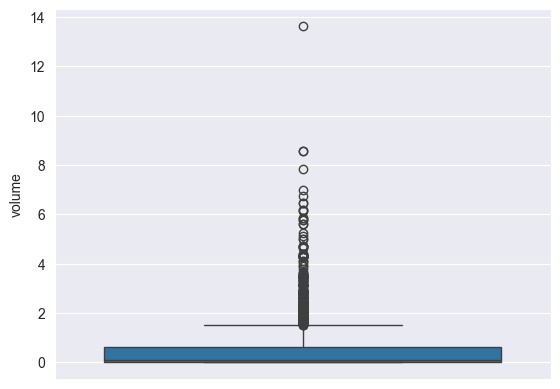

In [31]:
sns.boxplot(y='volume', data=df_ikea)

> Можна зробити висновок, що товари мають дуже різні розміри. Велика різниця між середнім значенням та медіаною вказує на великий вплив викидів 

In [32]:
# Видаляємо зайві колонки
df_ikea_norm = df_ikea.drop(columns=['Unnamed: 0', 'item_id', 'category', 'old_price', 'link', 'designer', 'short_description'])
df_ikea_norm.shape

(2962, 10)

### Описова статистика

In [33]:
# Подивимось на товари, які були продані офлайн
df_ikea_norm[df_ikea_norm['sellable_online'] == False]

,name,price,sellable_online,other_colors,depth,height,width,product,designer_normalized,volume
1,NORDVIKEN,995.0,False,No,NaN,105.0,80.0,Bar table,Francis Cayouette,0.008400
2,NORDVIKEN / NORDVIKEN,2095.0,False,No,NaN,NaN,NaN,Bar table and 4 bar stools,Francis Cayouette,0.000001
36,NORDVIKEN,275.0,False,No,47.0,101.0,40.0,Bar stool with backrest,Francis Cayouette,0.189880
52,SLÄKT,540.0,False,No,NaN,NaN,91.0,Ext bed frame with slatted bed base,Ebba Strandmark/IKEA of Sweden,0.000091
160,SLÄKT,520.0,False,No,NaN,NaN,91.0,Ext bed frame with slatted bed base,Ebba Strandmark/IKEA of Sweden,0.000091
223,SLÄKT,75.0,False,Yes,NaN,40.0,90.0,Headboard,Ebba Strandmark,0.003600
618,HACKÅS,50.0,False,No,18.0,NaN,24.0,Handle,J Löfgren/J Pettersson,0.000432
1503,VOLFGANG,175.0,False,No,43.0,85.0,53.0,Stool,without designer,0.193715
1553,EKEDALEN / EKEDALEN,1245.0,False,No,NaN,NaN,NaN,Table and 2 chairs,Ehlén Johansson,0.000001
1579,EKEDALEN / ODGER,1149.0,False,No,NaN,NaN,NaN,Table and 2 chairs,Ehlén Johansson/J Löfgren/J Pettersson,0.000001


In [34]:
# Подивимось який розкид цін у наборі даних
df_ikea_norm['price'].describe()

count    2962.000000
mean     1108.722552
std      1393.576103
min         3.000000
25%       200.000000
50%       570.000000
75%      1475.000000
max      9585.000000
Name: price, dtype: float64

Text(0.5, 1.0, 'Range of prices')

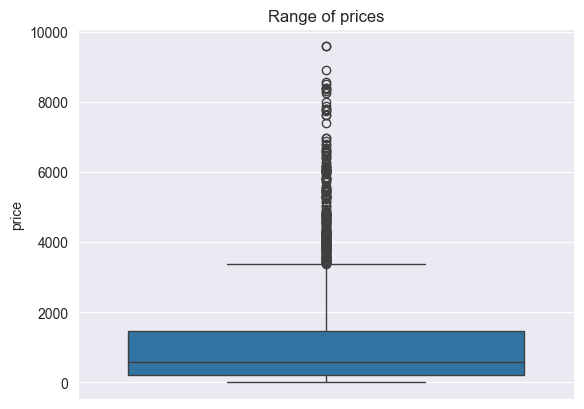

In [35]:
# Візуалізуємо розкид цін
sns.boxplot(y='price' , data=df_ikea_norm)
plt.title('Range of prices')

Text(0.5, 1.0, 'Range of prices of selling types')

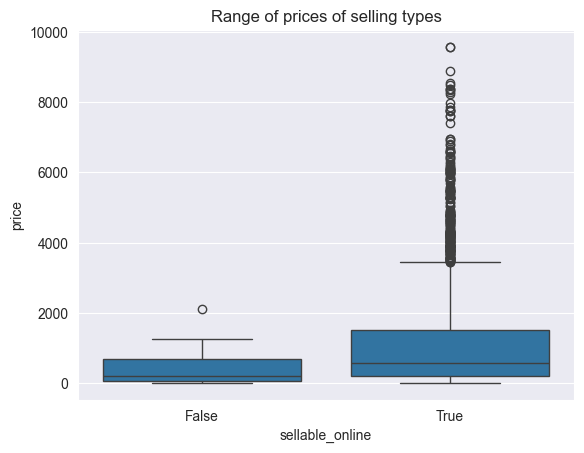

In [36]:
# Візуалізуємо розкид цін в залежності від типу продажу
sns.boxplot(y='price', x= 'sellable_online' , data=df_ikea_norm)
plt.title('Range of prices of selling types')

Text(0.5, 1.0, 'Quantity of sales of price and selling types')

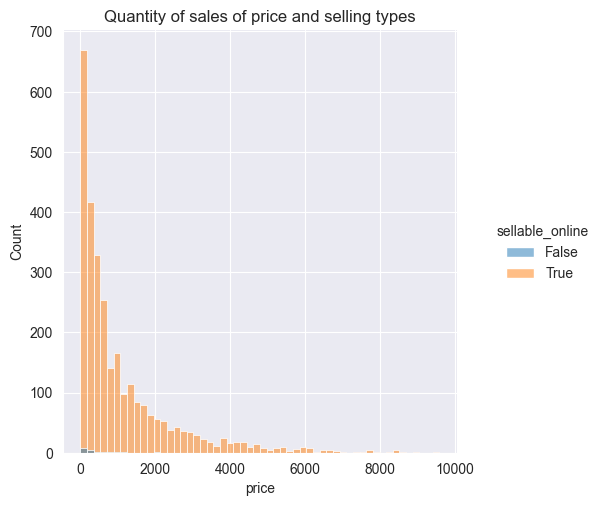

In [37]:
# Візуалізуємо залежність кількості проданих товарів від ціни та типу продажу
sns.displot(x='price', hue='sellable_online', data=df_ikea_norm)
plt.title('Quantity of sales of price and selling types')

> Проаналізувавши залежність ціни від типу продажу, можна зробити висновок, що товари проданні офлайн мають дещо меншу ціну, проте кількість проданих офлайн товарів становить менше як 1% загальних продажів (19 з 2962)

Text(0.5, 1.0, 'Quantity of sales of price and colors')

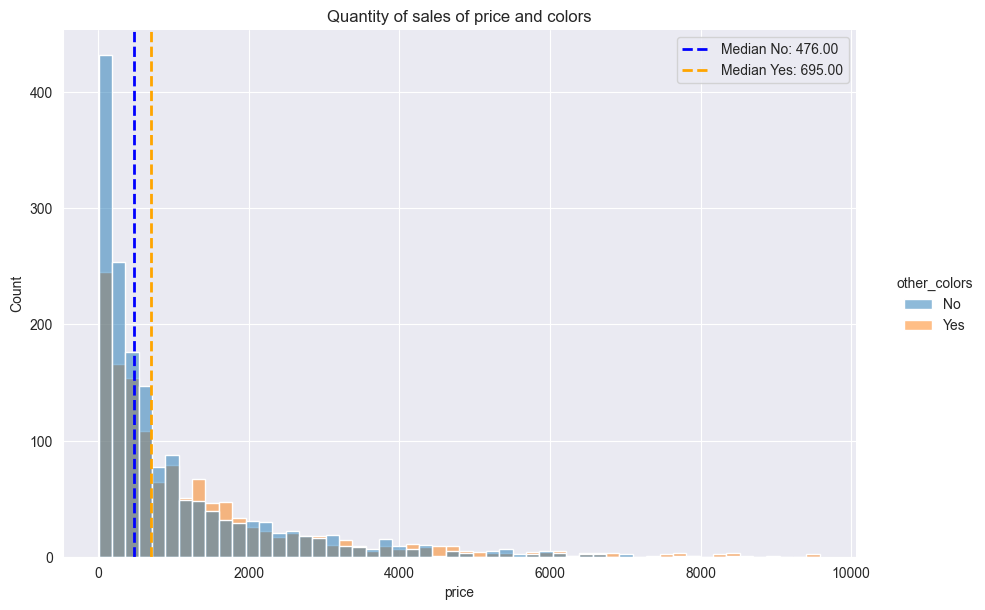

In [38]:
# Візуалізуємо залежність кількості проданих товарів від ціни та наявності інших кольорів

# Calculate medians
median_no = df_ikea_norm[df_ikea_norm['other_colors'] == 'No']['price'].median()
median_yes = df_ikea_norm[df_ikea_norm['other_colors'] == 'Yes']['price'].median()

# Create the distribution plot
sns.displot(x='price', hue='other_colors', data=df_ikea_norm, kde=False, height=6, aspect=1.5)

# Add vertical lines for the medians
plt.axvline(median_no, color='blue', linestyle='dashed', linewidth=2, label=f'Median No: {median_no:.2f}')
plt.axvline(median_yes, color='orange', linestyle='dashed', linewidth=2, label=f'Median Yes: {median_yes:.2f}')
plt.legend()
plt.title('Quantity of sales of price and colors')

Text(0.5, 1.0, 'Quantity of sales of colors')

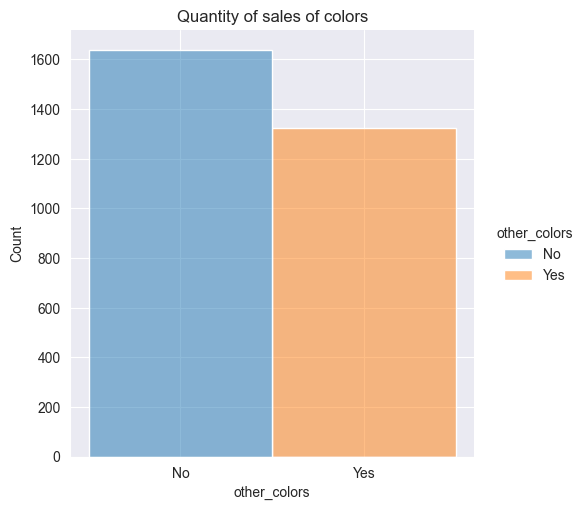

In [39]:
# Візуалізуємо залежність кількості проданих товарів від наявності інших кольорів
sns.displot(x='other_colors', hue='other_colors', data=df_ikea_norm)
plt.title('Quantity of sales of colors')

Text(0.5, 1.0, 'Range of prices of colors')

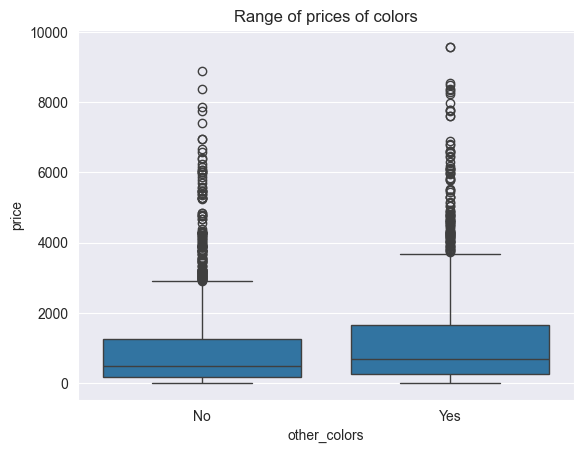

In [40]:
# Візуалізуємо розкид цін в залежності від наявності інших кольорів
sns.boxplot(x='other_colors', y='price', data=df_ikea_norm)
plt.title('Range of prices of colors')

> Проаналізувавши залежність ціни від наявності інших кольорів, можна зробити висновок, що товари які мають варіації кольорів мають вищу ціну

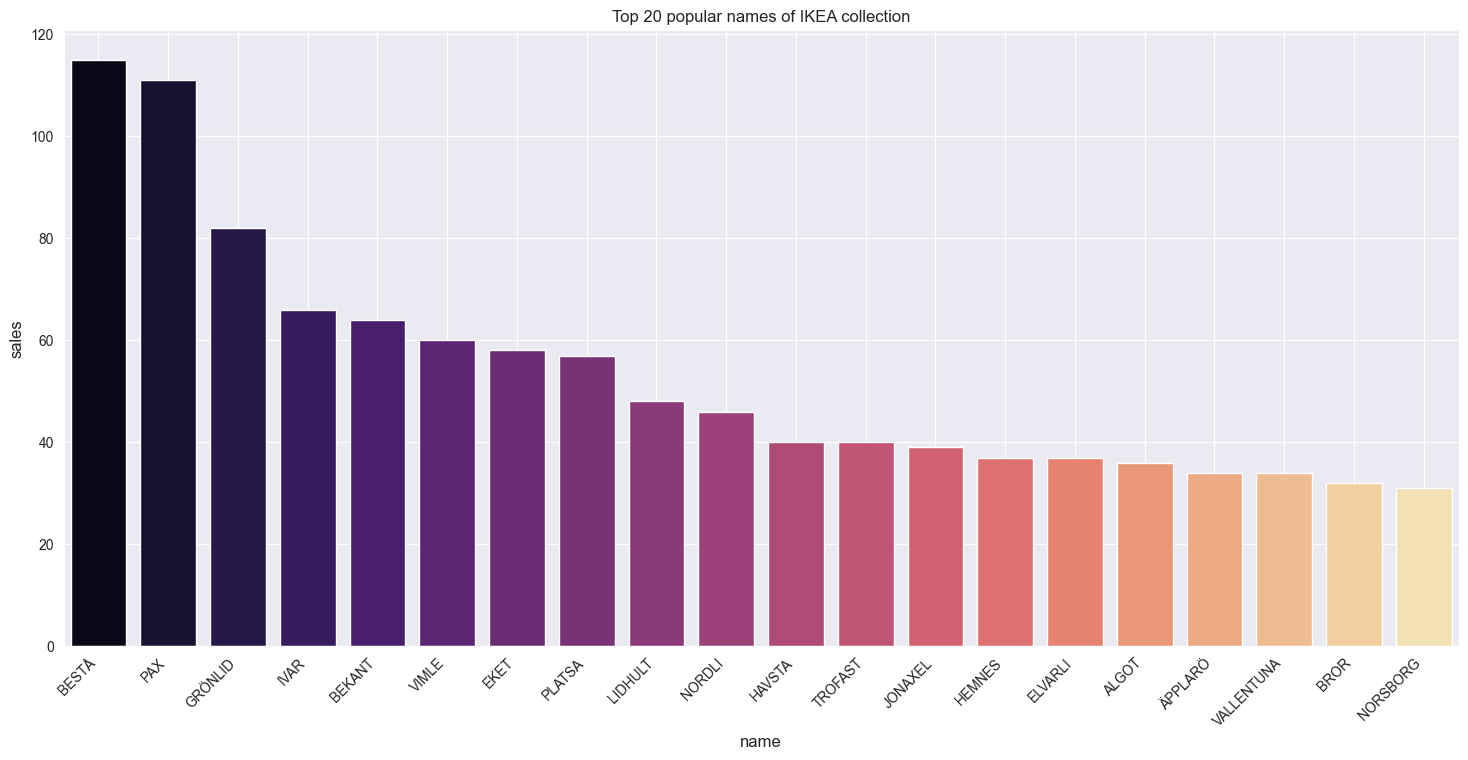

In [41]:
# Візуалізуємо 20 найбільш популярних колекцій за продажами 

# Calculate top 20 names
name_count = df_ikea_norm['name'].value_counts().reset_index().iloc[:20]

# Create the distribution plot
plt.figure(figsize=(18,8))
plot = sns.barplot(x = 'name', y = 'count', data = name_count,hue='name',  palette= 'magma', legend=False)

# Add labels
plot.set_xticklabels(plot.get_xticklabels(), rotation=45,  horizontalalignment='right')
plt.title('Top 20 popular names of IKEA collection')
plt.ylabel('sales', fontsize=12)
plt.xlabel('name', fontsize=12)
plt.grid(True)

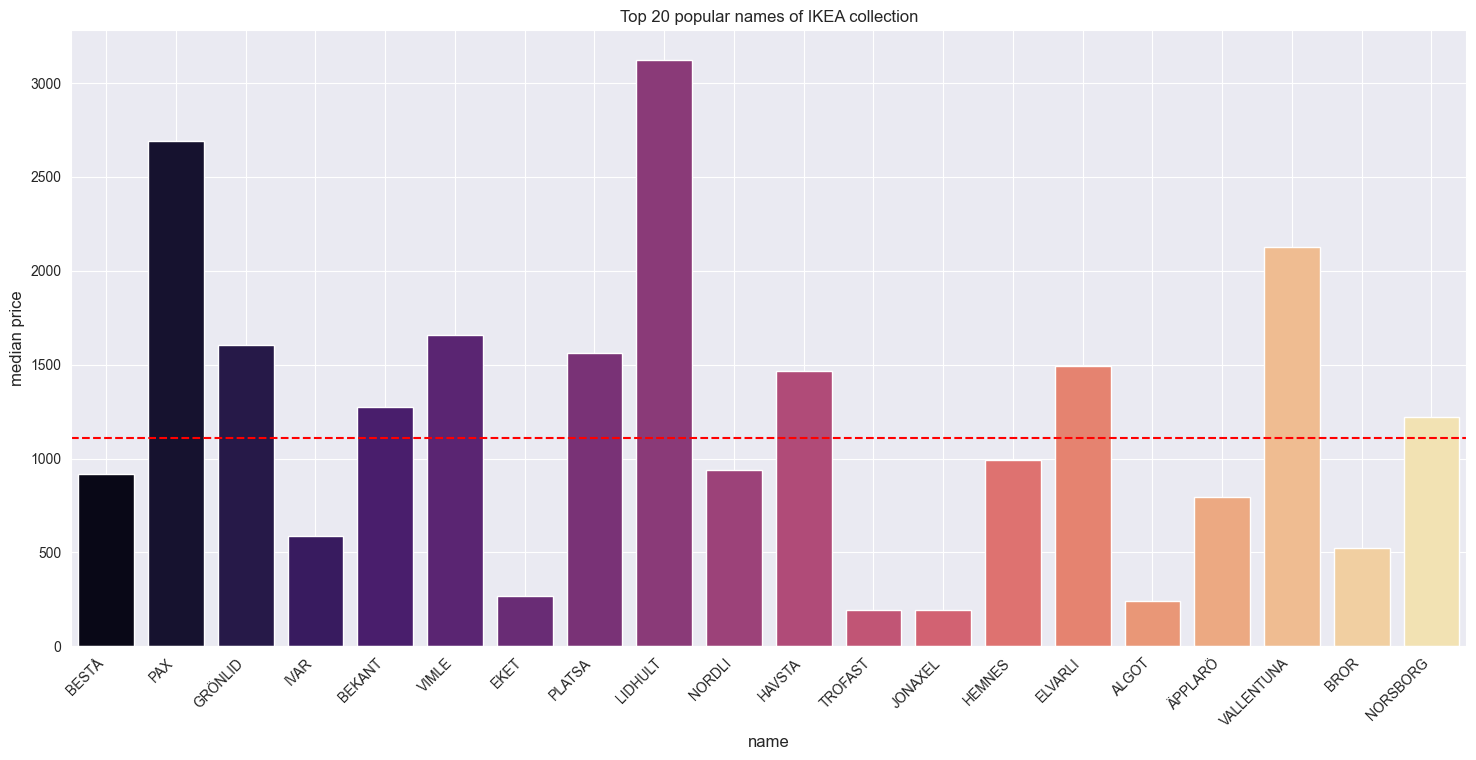

In [42]:
# Візуалізуємо 20 найбільш популярних колекцій за ціною 

# Calculate median for top 20 names
name_median =  df_ikea_norm.groupby('name')['price'].median().reset_index()
top_20_name = pd.merge(name_count, name_median, on = 'name', how = 'left')

# Create the distribution plot
plt.figure(figsize=(18,8))
plot = sns.barplot(x = 'name', y = 'price', data = top_20_name, hue='name',  palette= 'magma', legend=False)

# Add labels and additional line
plot.set_xticklabels(plot.get_xticklabels(), rotation=45,  horizontalalignment='right')
plt.title('Top 20 popular names of IKEA collection')
plt.ylabel('median price', fontsize=12)
plt.xlabel('name', fontsize=12)
plt.axhline(y=np.nanmedian(top_20_name.price), color='r', linestyle='--')
plt.grid(True)

Text(0.5, 1.0, 'Top 20 popular names of IKEA collection')

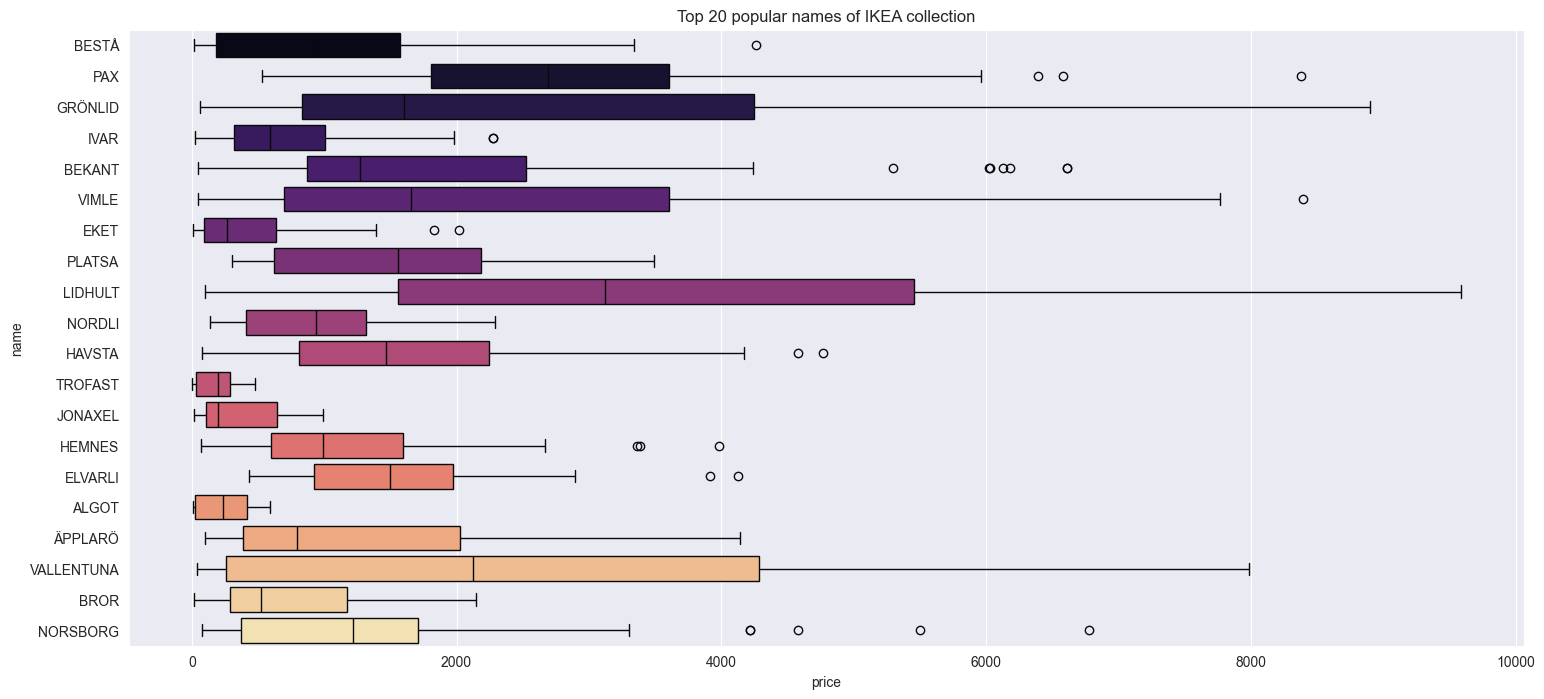

In [43]:
# Візуалізуємо розкид цін по 20 найбільш популярних колекціях

# Calculate price for top 20 names
top_20_name_price = pd.merge(name_count, df_ikea_norm, on = 'name', how = 'left')

# Create the distribution plot
plt.figure(figsize=(18,8))
sns.boxplot(y = 'name', x = 'price', data = top_20_name_price, palette= 'magma')
plt.title('Top 20 popular names of IKEA collection')

Text(0.5, 1.0, 'Range of prices of popular names')

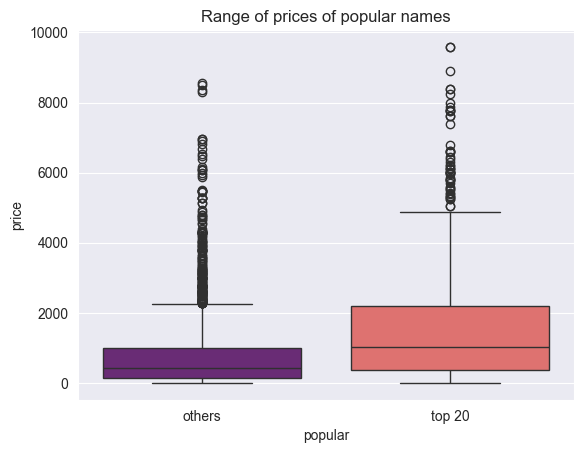

In [44]:
# Візуалізуємо розкид цін в залежності від популярності колекції

# Make df with other names
name_price_others = pd.merge(name_count, df_ikea_norm, on = 'name', how = 'right', indicator=True)
name_price_others_df = name_price_others[name_price_others['_merge'] == 'right_only'].reset_index()

# Create new column to identify popularity
name_price_others_df['popular'] = 'others'
top_20_name_price['popular'] = 'top 20'

# Make combine df
df_name_popular = pd.concat([name_price_others_df, top_20_name_price], axis = 0, join = 'outer')

# Create the distribution plot
sns.boxplot(x = 'popular', y = 'price', data = df_name_popular, hue='popular', palette= 'magma')
plt.title('Range of prices of popular names')

> Проаналізувавши вплив назви колекції на ціну, можна зробити висновок, що назва колекції впливає на ціну, також існує залежність між популярністю колекції та ціною, популярні колекції мають більшу ціну.

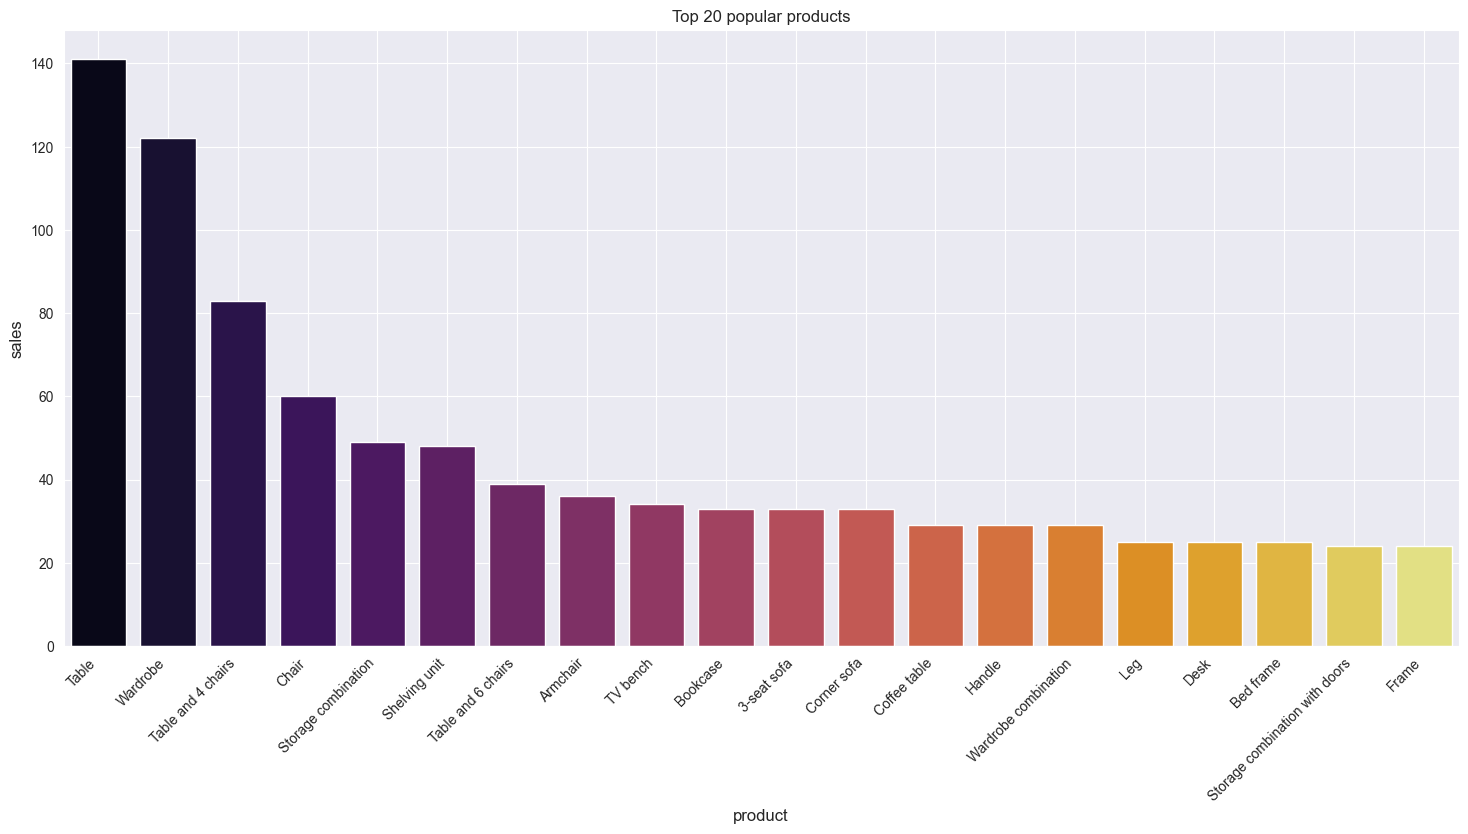

In [45]:
# Візуалізуємо 20 найбільш популярних товарів за продажами 

# Calculate top 20 products
product_count = df_ikea_norm['product'].value_counts().reset_index().iloc[:20]

# Create the distribution plot
plt.figure(figsize=(18,8))
plot = sns.barplot(x = 'product', y = 'count', data = product_count, hue='product',  palette= 'inferno', legend=False)

# Add labels
plot.set_xticklabels(plot.get_xticklabels(), rotation=45,  horizontalalignment='right')
plt.title('Top 20 popular products')
plt.ylabel('sales', fontsize=12)
plt.xlabel('product', fontsize=12)
plt.grid(True)

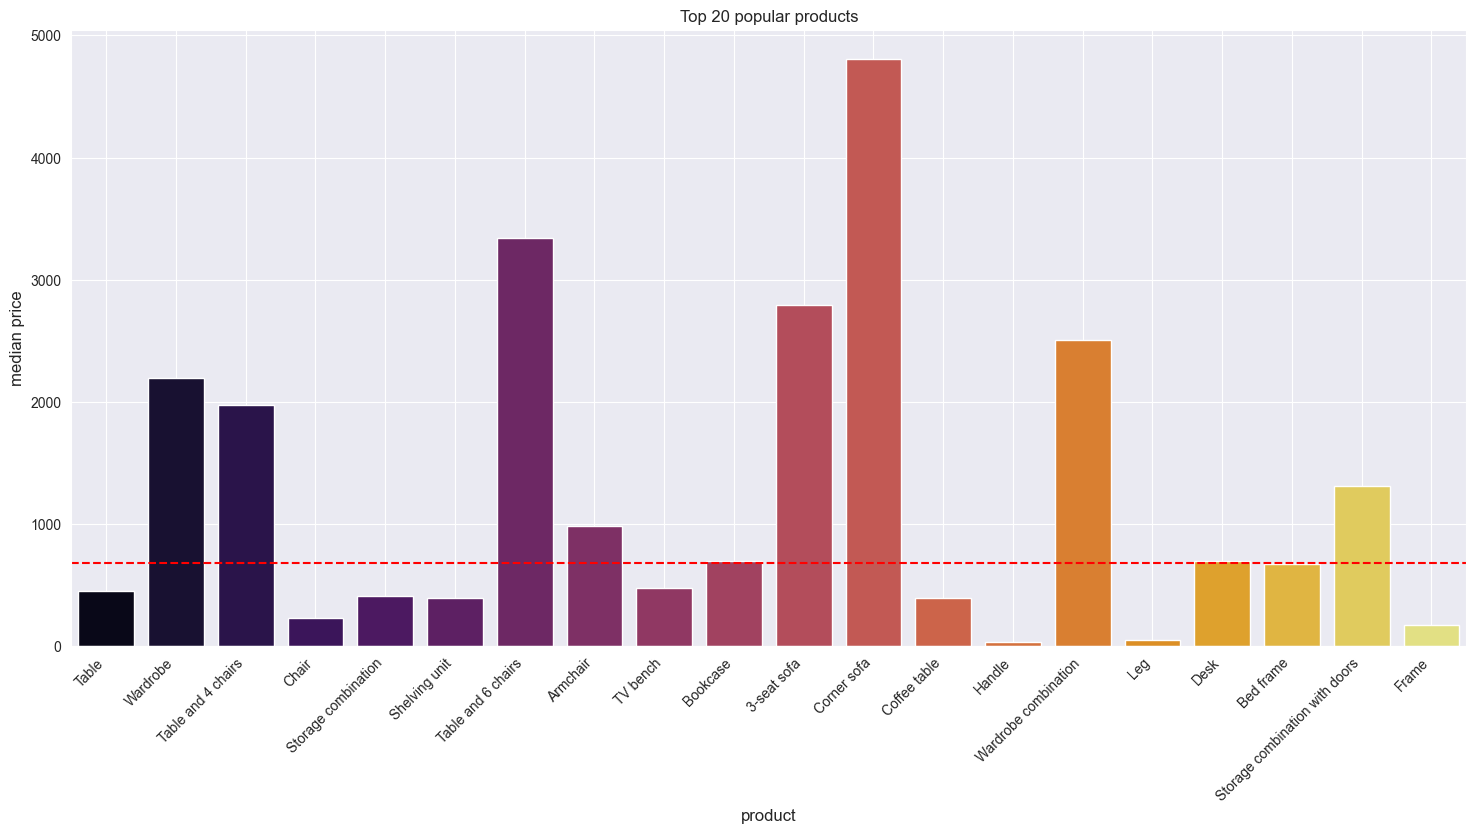

In [46]:
# Візуалізуємо 20 найбільш популярних товарів за ціною 

# Calculate median for top 20 products
product_median =  df_ikea_norm.groupby('product')['price'].median().reset_index()
top_20_products = pd.merge(product_count, product_median, on = 'product', how = 'left')

# Create the distribution plot
plt.figure(figsize=(18,8))
plot = sns.barplot(x = 'product', y = 'price', data = top_20_products, hue='product',  palette= 'inferno', legend=False)

# Add labels and additional line
plot.set_xticklabels(plot.get_xticklabels(), rotation=45,  horizontalalignment='right')
plt.title('Top 20 popular products')
plt.ylabel('median price', fontsize=12)
plt.xlabel('product', fontsize=12)
plt.axhline(y=np.nanmedian(top_20_products.price), color='r', linestyle='--')
plt.grid(True)

Text(0.5, 1.0, 'Top 20 popular products')

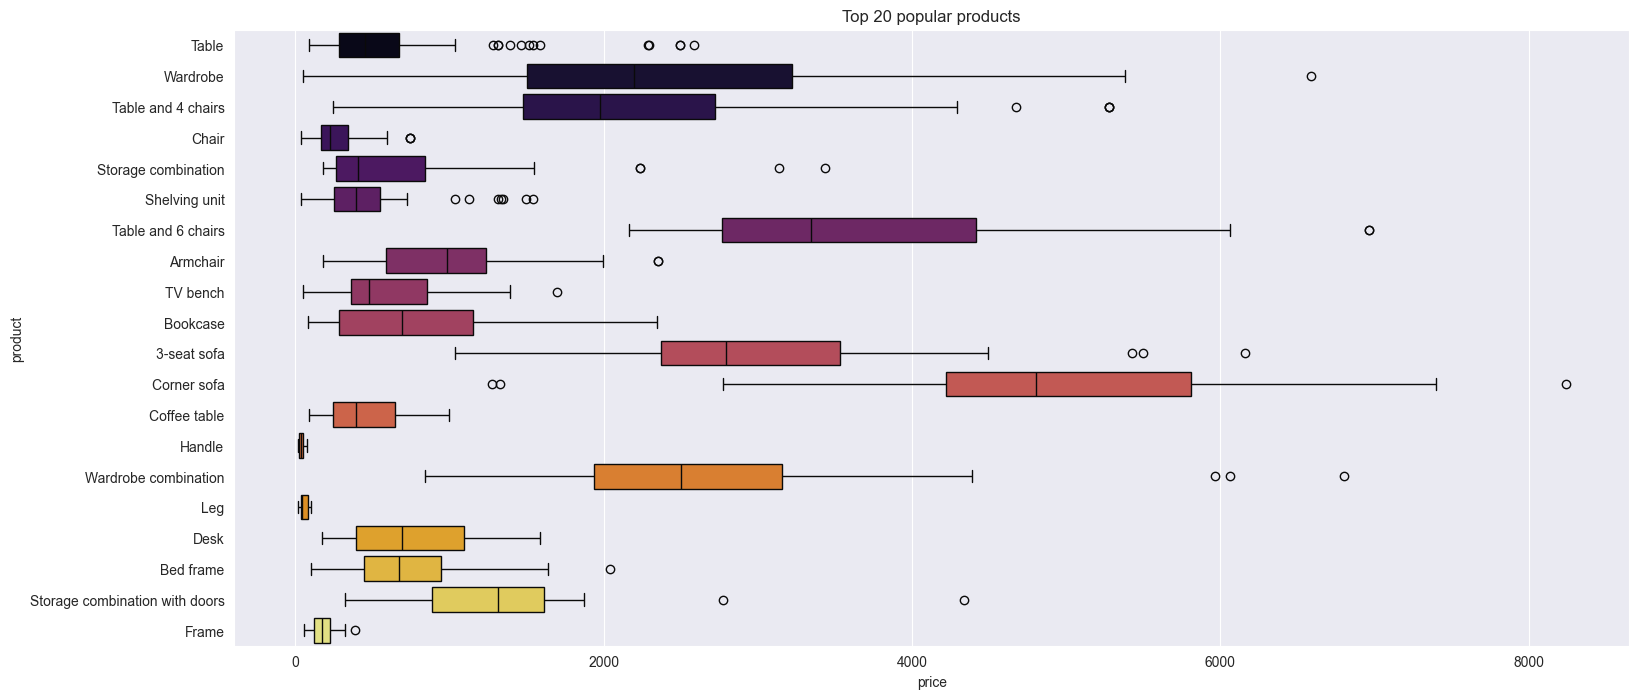

In [47]:
# Візуалізуємо розкид цін по 20 найбільш популярних товарах

# Calculate price for top 20 products
top_20_product_price = pd.merge(product_count, df_ikea_norm, on = 'product', how = 'left')

# Create the distribution plot
plt.figure(figsize=(18,8))
sns.boxplot(y = 'product', x = 'price', data = top_20_product_price, palette = 'inferno')
plt.title('Top 20 popular products')

Text(0.5, 1.0, 'Range of prices of popular products')

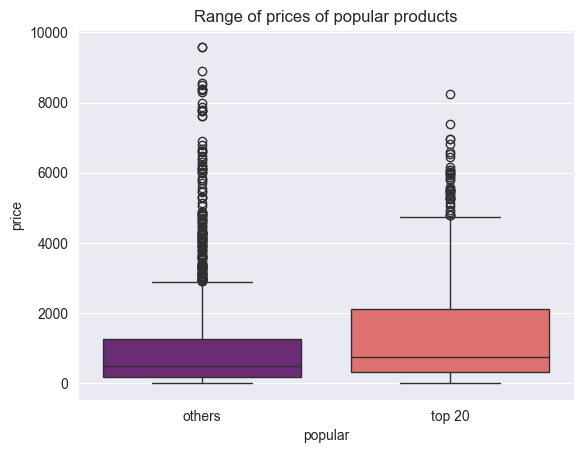

In [48]:
# Візуалізуємо розкид цін в залежності від популярності товару

# Make df with other names
product_price_others = pd.merge(product_count, df_ikea_norm, on = 'product', how = 'right', indicator=True)
product_price_others_df = product_price_others[product_price_others['_merge'] == 'right_only'].reset_index()

# Create new column to identify popularity
product_price_others_df['popular'] = 'others'
top_20_product_price['popular'] = 'top 20'

# Make combine df
df_product_popular = pd.concat([product_price_others_df, top_20_product_price], axis = 0, join = 'outer')

# Create the distribution plot
sns.boxplot(x = 'popular', y = 'price', data = df_product_popular, hue='popular', palette= 'magma')
plt.title('Range of prices of popular products')

> Проаналізувавши вплив товару на ціну, можна зробити висновок, що назва товару впливає на ціну, також існує залежність між популярністю товару та ціною, популярні товари мають дещо більшу ціну.

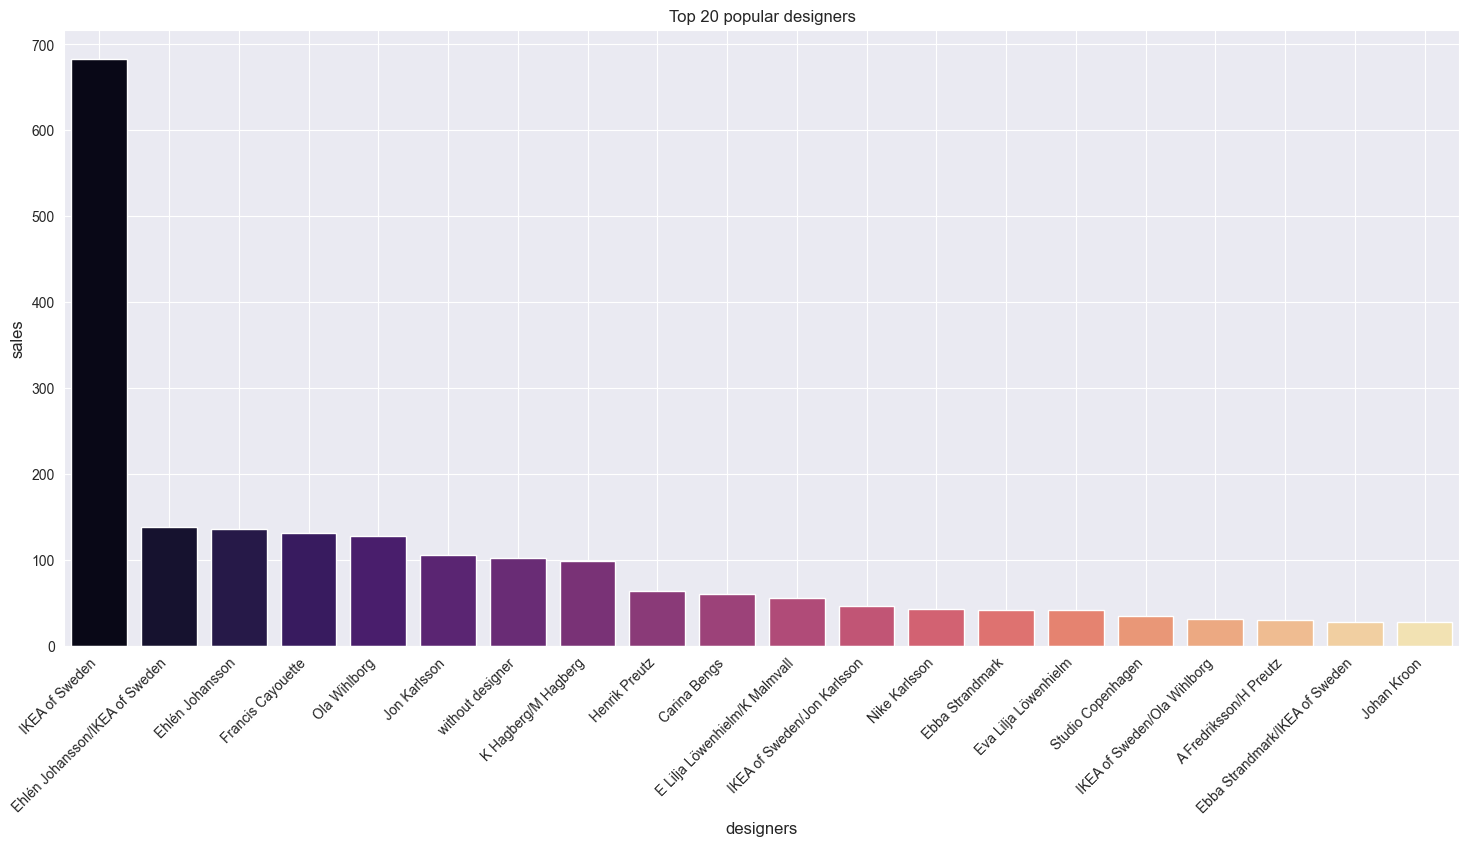

In [49]:
# Візуалізуємо 20 найбільш популярних дизайнерів за продажами 

# Calculate top 20 designers
designer_count = df_ikea_norm['designer_normalized'].value_counts().reset_index().iloc[:20]

# Create the distribution plot
plt.figure(figsize=(18,8))
plot = sns.barplot(x = 'designer_normalized', y = 'count', data = designer_count, hue='designer_normalized',  palette= 'magma', legend=False)

# Add labels
plot.set_xticklabels(plot.get_xticklabels(), rotation=45,  horizontalalignment='right')
plt.title('Top 20 popular designers')
plt.ylabel('sales', fontsize=12)
plt.xlabel('designers', fontsize=12)
plt.grid(True)

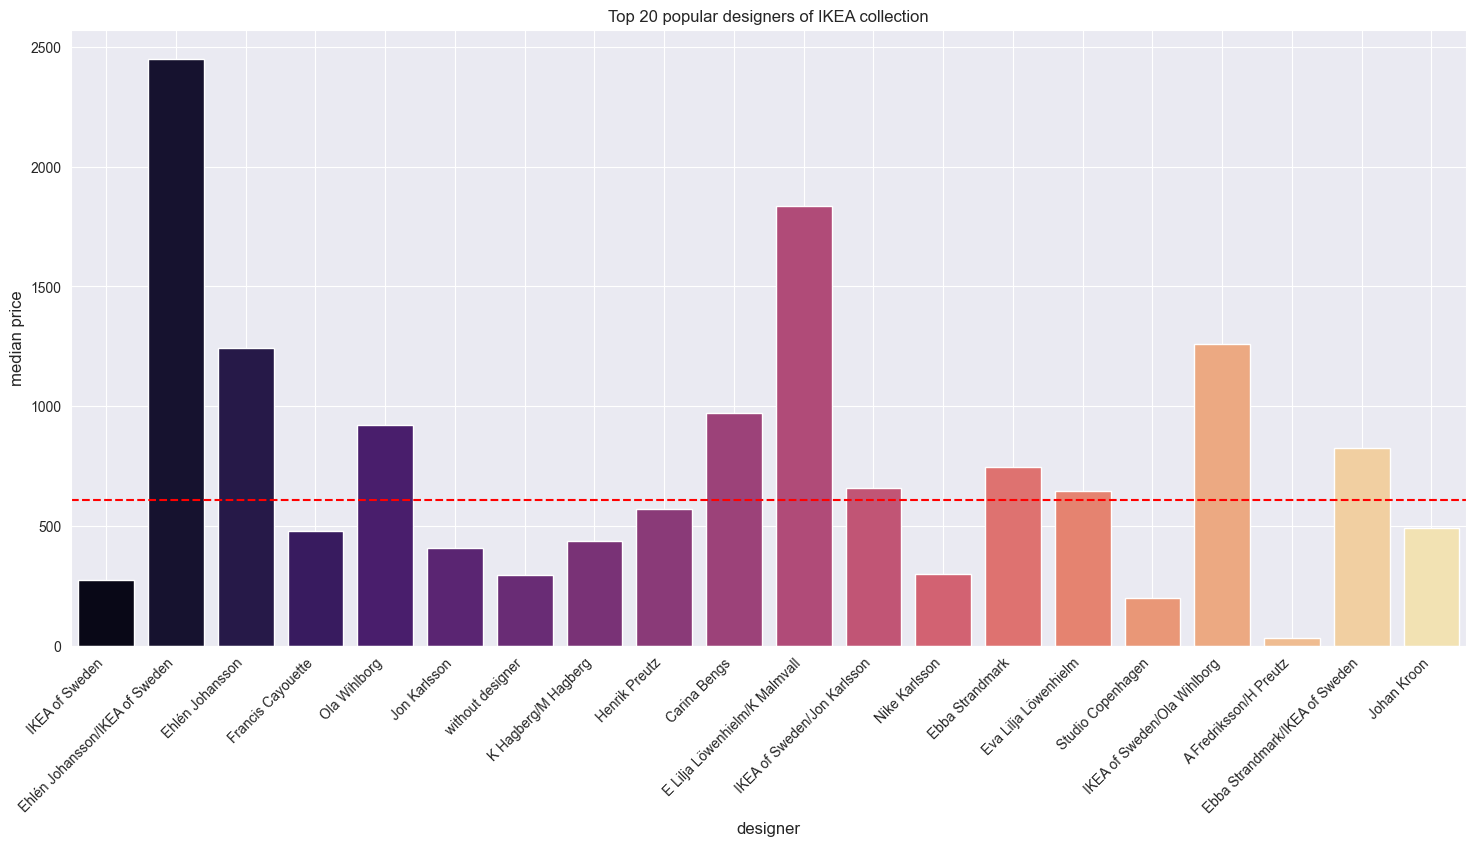

In [50]:
# Візуалізуємо 20 найбільш популярних дизайнерів за ціною 

# Calculate median for top 20 designers
designer_median =  df_ikea_norm.groupby('designer_normalized')['price'].median().reset_index()
top_20_designers = pd.merge(designer_count, designer_median, on = 'designer_normalized', how = 'left')

# Create the distribution plot
plt.figure(figsize=(18,8))
plot = sns.barplot(x = 'designer_normalized', y = 'price', data = top_20_designers, hue='designer_normalized',  palette= 'magma', legend=False)

# Add labels and additional line
plot.set_xticklabels(plot.get_xticklabels(), rotation=45,  horizontalalignment='right')
plt.title('Top 20 popular designers of IKEA collection')
plt.ylabel('median price', fontsize=12)
plt.xlabel('designer', fontsize=12)
plt.axhline(y=np.nanmedian(top_20_designers.price), color='r', linestyle='--')
plt.grid(True)

Text(0.5, 1.0, 'Top 20 popular designers of IKEA collection')

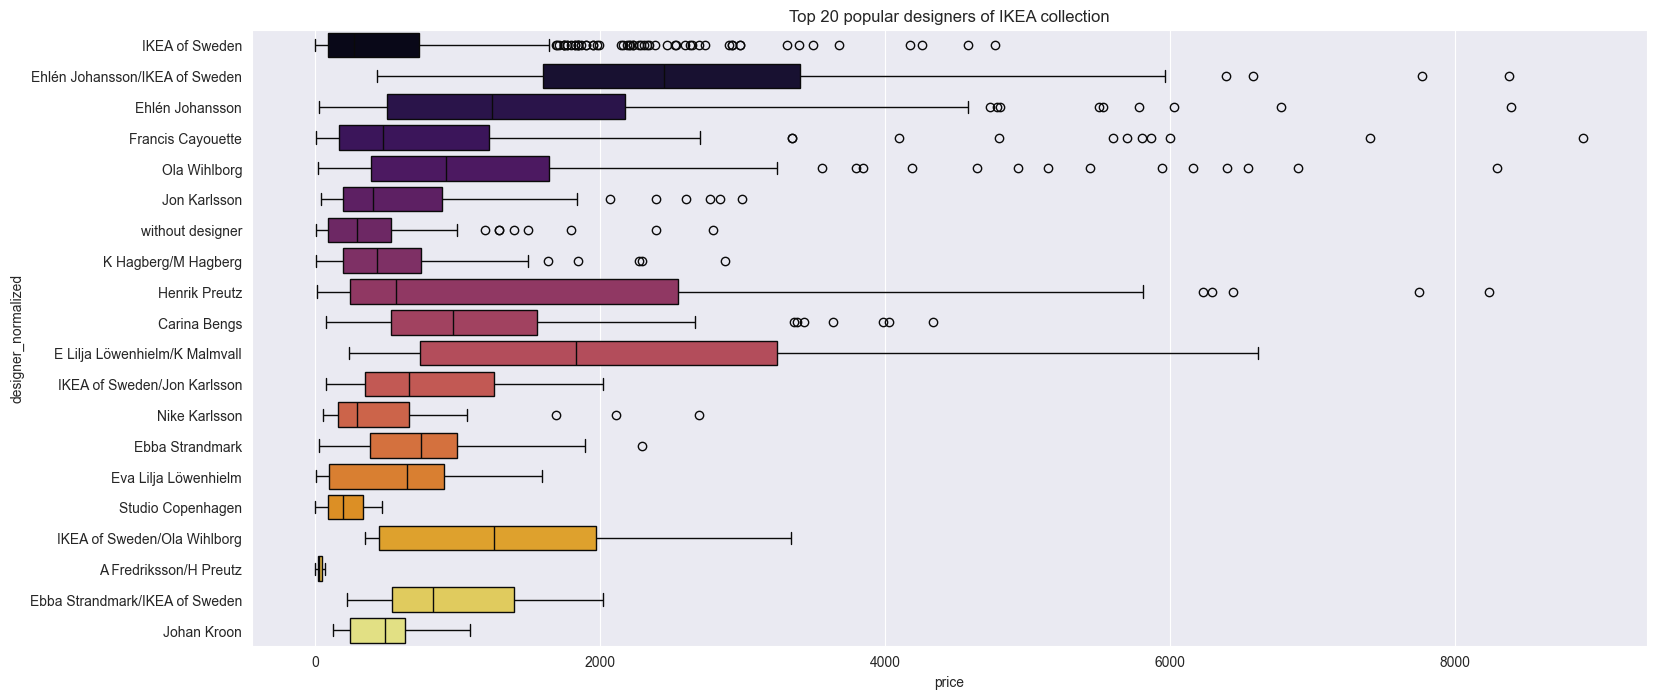

In [51]:
# Візуалізуємо розкид цін по 20 найбільш популярних дизайнерах

# Calculate price for top 20 products
top_20_designer_price = pd.merge(designer_count, df_ikea_norm, on = 'designer_normalized', how = 'left')

# Create the distribution plot
plt.figure(figsize=(18,8))
sns.boxplot(y = 'designer_normalized', x = 'price', data = top_20_designer_price, palette = 'inferno')
plt.title('Top 20 popular designers of IKEA collection')

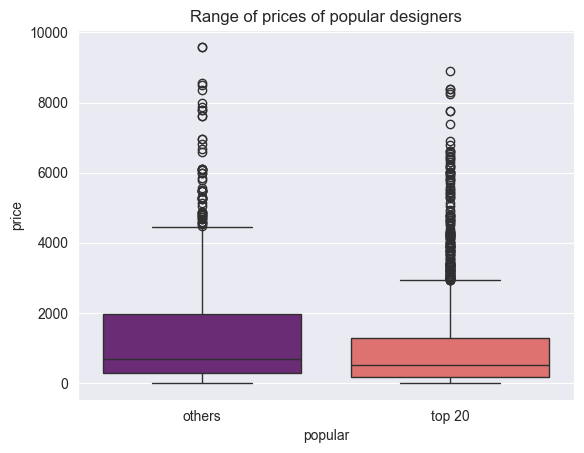

Text(0.5, 1.0, 'Range of prices of popular designers without IKEA of Sweden')

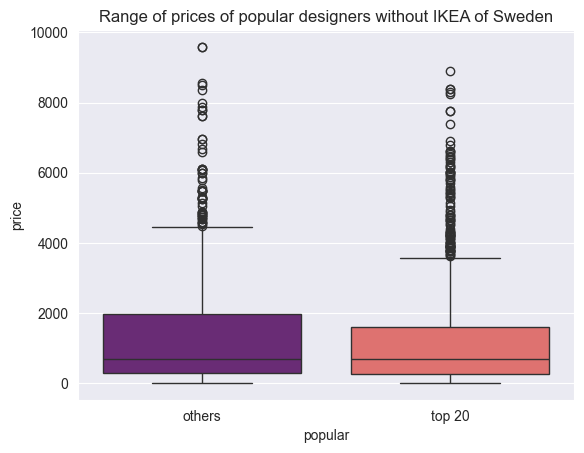

In [52]:
# Візуалізуємо розкид цін в залежності від популярності дизайнера

# Make df with other names
designer_price_others = pd.merge(designer_count, df_ikea_norm, on = 'designer_normalized', how = 'right', indicator=True)
designer_price_others_df = designer_price_others[designer_price_others['_merge'] == 'right_only'].reset_index()

# Create new column to identify popularity
designer_price_others_df['popular'] = 'others'
top_20_designer_price['popular'] = 'top 20'

# Make combine df
df_designer_popular = pd.concat([designer_price_others_df, top_20_designer_price], axis = 0, join = 'outer')

# Create the distribution plot
sns.boxplot(x = 'popular', y = 'price', data = df_designer_popular, hue='popular', palette= 'magma')
plt.title('Range of prices of popular designers')
plt.show()
without_ikea_sweden = df_designer_popular[df_designer_popular['designer_normalized'] != 'IKEA of Sweden']
sns.boxplot(x = 'popular', y = 'price', data = without_ikea_sweden, hue='popular', palette= 'magma')
plt.title('Range of prices of popular designers without IKEA of Sweden')

> Проаналізувавши вплив дизайнера на ціну, можна зробити висновок, що ім'я дизайнера впливає на ціну, також існує залежність між популярністю дизайнера та ціною, товари від популярних дизайнерів мають дещо меншу ціну.

In [53]:
# Розраховуємо кореляцію ціни та розмірів товару
df_ikea_norm.corr(method='pearson', numeric_only=True)

,price,sellable_online,depth,height,width,volume
price,1.000000,0.037616,0.630683,0.278548,0.720389,0.624429
sellable_online,0.037616,1.000000,0.060301,0.043802,0.057360,0.039467
depth,0.630683,0.060301,1.000000,-0.099405,0.424394,0.626671
height,0.278548,0.043802,-0.099405,1.000000,0.368775,0.452655
width,0.720389,0.057360,0.424394,0.368775,1.000000,0.732381
volume,0.624429,0.039467,0.626671,0.452655,0.732381,1.000000


<Axes: >

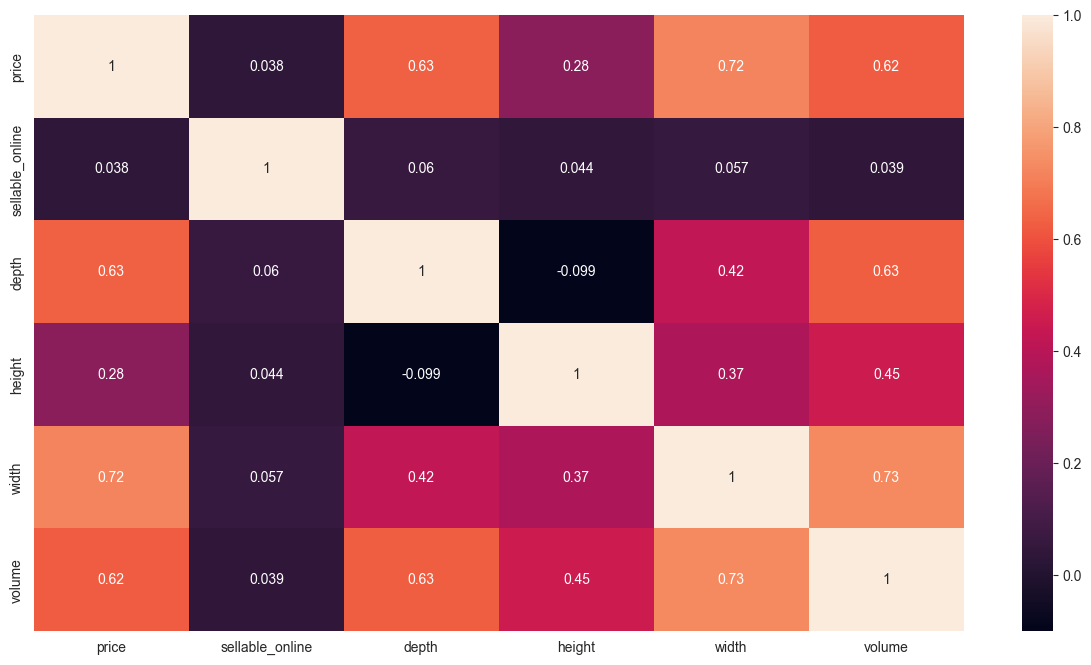

In [54]:
# Візуалізуємо кореляцію Пірсона ціни та розмірів товару
plt.figure(figsize=(15,8))
sns.heatmap(df_ikea_norm.corr(method='pearson', numeric_only=True), annot=True)

<Axes: >

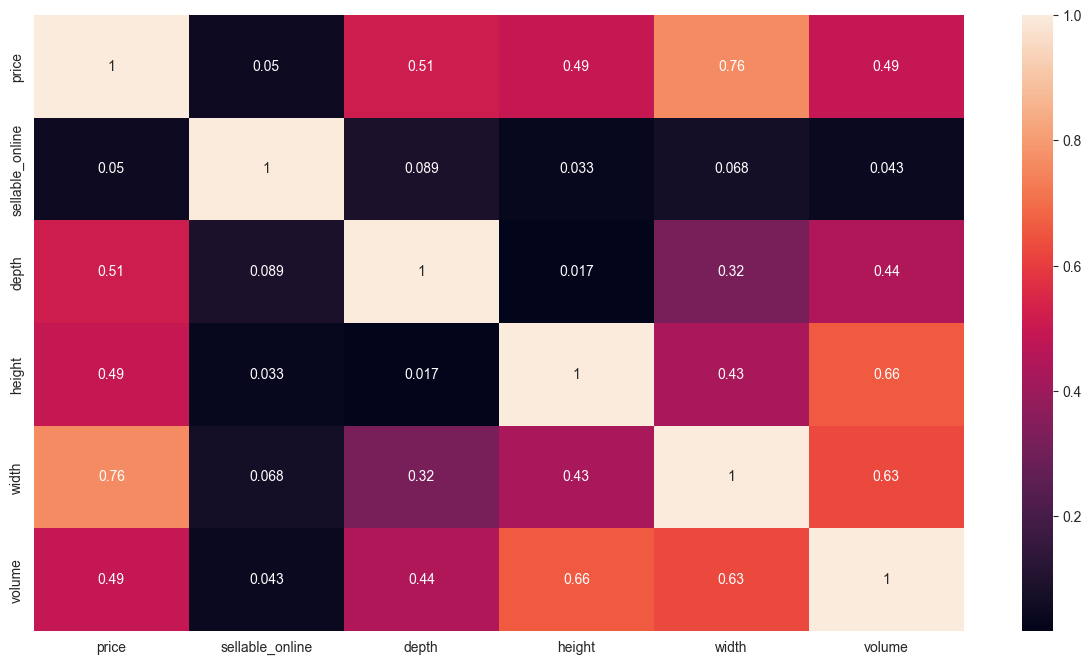

In [55]:
# Візуалізуємо кореляцію Спірмена ціни та розмірів товару
plt.figure(figsize=(15,8))
sns.heatmap(df_ikea_norm.corr(method='spearman', numeric_only=True), annot=True)

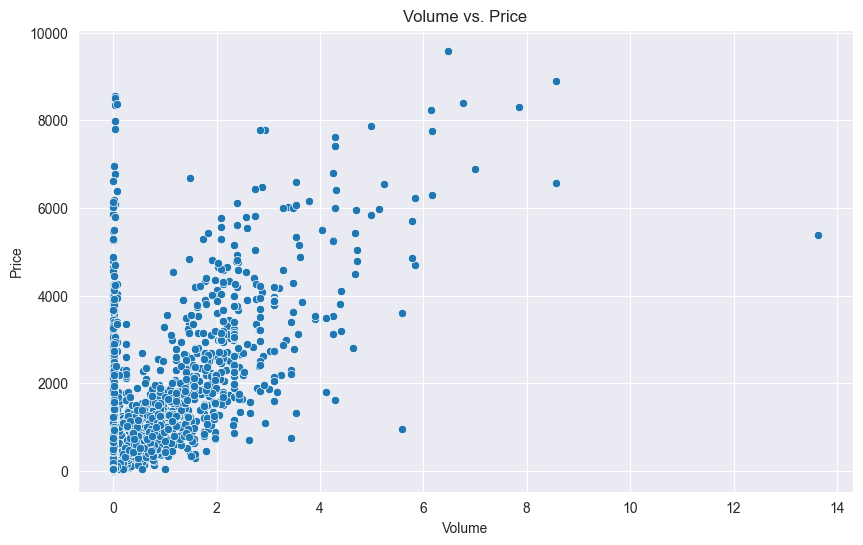

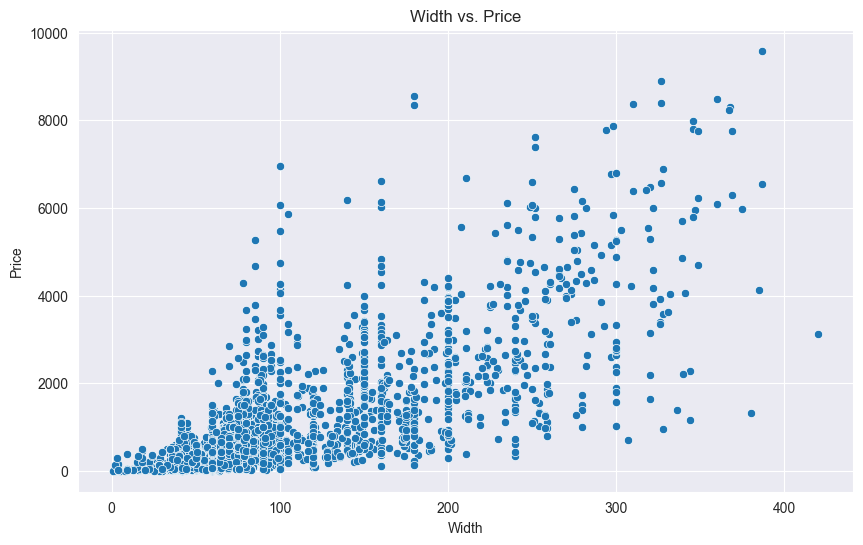

In [56]:
# Візуалізуємо розкид цін в залежності від розміру товару
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_ikea_norm, x='volume', y='price')
plt.title('Volume vs. Price')
plt.xlabel('Volume')
plt.ylabel('Price')
plt.show()
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_ikea_norm, x='width', y='price')
plt.title('Width vs. Price')
plt.xlabel('Width')
plt.ylabel('Price')
plt.show()

> Проаналізувавши залежність між розмірами товару та ціною, можна зробити висновок, що чим більший за розмірами товар, тим він дорожчий. Особливо впливає ширина товару на ціну.

#### В результаті проведеного аналізу, можна сформувати наступні гіпотези:
> **Гіпотеза 1**: розподіл ціни в набрі даних має ознаки не нормального розподілу;
> 
> **Гіпотеза 2**: товари які мають варіації кольорів мають вищу ціну;
> 
> **Гіпотеза 3**: назва колекції впливає на ціну;
> 
> **Гіпотеза 3_1**: популярні колекції мають більшу ціну;
> 
> **Гіпотеза 4**: назва товару впливає на ціну;
> 
> **Гіпотеза 4_1**: популярні товари мають більшу ціну;
> 
> **Гіпотеза 5**: ім'я дизайнера впливає на ціну;
> 
> **Гіпотеза 5_1**: товари від популярних дизайнерів мають дещо меншу ціну;
> 
> **Гіпотеза 6**: розмір товару впливає на ціну.

---
> **Гіпотеза 1**: розподіл ціни в набрі даних має ознаки не нормального розподілу
>> Нульова гіпотеза (Н0) випадкова величина ціни розподілена нормально;
> 
>> Альтернативна гіпотеза (Н1) випадкова величина ціни розподілена не нормально.

p-value 0.0000000000
0.7326762704994496


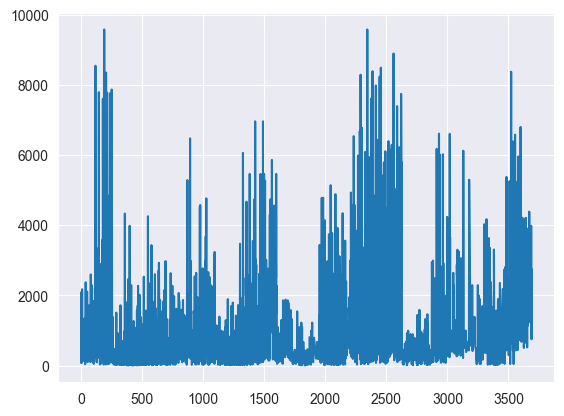

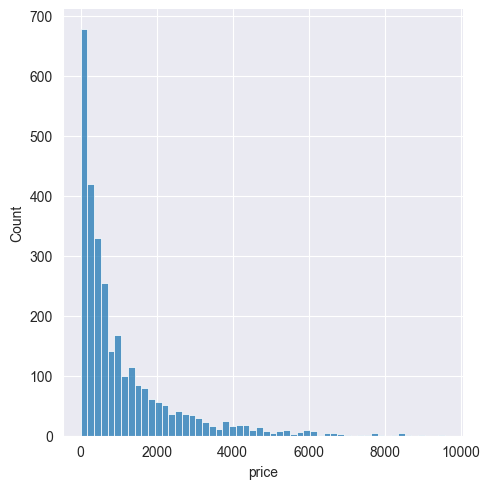

In [57]:
# Використовуємо метод Шапіро-Вілка
sample = df_ikea_norm['price']
stat, p = stats.shapiro(sample)
print(f'p-value {p:.10f}')
plt.plot(sample)
print(stat)
sns.displot(sample);
plt.show()

>  p-value близьке до нуля, що менше ніж 0,05, а отже можна відкинути нульову гіпотезу і прийняти альтернативну, що в даному наборі даних значення ціни розподілено не нормально.

---
> **Гіпотеза 2**: товари які мають варіації кольорів мають вищу ціну
>> Нульова гіпотеза (Н0) товари які мають варіації кольорів та товари без варіації кольорів мають однакову середню ціну;
> 
>> Альтернативна гіпотеза (Н1) товари які мають варіації кольорів та товари без варіації кольорів мають різну середню ціну.

In [58]:
# t-test

# Filter data
single_color = df_ikea_norm[df_ikea_norm['other_colors'] == 'No']['price']
multi_color = df_ikea_norm[df_ikea_norm['other_colors'] == 'Yes']['price']


# Execute t-test
t_stat, p_value = stats.ttest_ind(single_color, multi_color, equal_var=False)
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value:.10f}")

# Checking hypothesis
if p_value < 0.05:
    print("Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на товари які мають варіації кольорів та товари без варіації кольорів.")
else:
    print("Ми не відхиляємо нульову гіпотезу: немає доказів статистично значущої різниці між цінами на товари які мають варіації кольорів та товари без варіації кольорів.")

T-statistic: -5.447223165236877
P-value: 0.0000000560
Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на товари які мають варіації кольорів та товари без варіації кольорів.


In [59]:
# Mann-Whitney U test. Використовуємо цей непараметричний метод, оскільки ми маємо не нормальний розподіл ціни та багато викидів по ціні.

# Execute U-test
u_statistic, p_value = stats.mannwhitneyu(single_color, multi_color)
print(f"U-statistic: {u_statistic}")
print(f"P-value: {p_value:.10f}")

# Checking hypothesis
if p_value < 0.05:
    print("Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на товари які мають варіації кольорів та товари без варіації кольорів.")
else:
    print("Ми не відхиляємо нульову гіпотезу: немає доказів статистично значущої різниці між цінами на товари які мають варіації кольорів та товари без варіації кольорів.")

U-statistic: 930008.5
P-value: 0.0000000000
Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на товари які мають варіації кольорів та товари без варіації кольорів.


> p-value близьке до нуля в обох тестах, що менше ніж 0,05, а отже можна відкинути нульову гіпотезу і прийняти альтернативну, також критерій T-statistic -5,4 вказує, що товари які мають різні варіації кольорів дорожче.

---
> **Гіпотеза 3**: назва колекції впливає на ціну
>> Нульова гіпотеза (Н0) товари з різних колекцій мають однакову середню ціну;
> 
>> Альтернативна гіпотеза (Н1) товари з різних колекцій мають різну середню ціну.

In [60]:
# ANOVA test

# Prepare the data for ANOVA
grouped_prices = [df_ikea_norm[df_ikea_norm['name'] == name]['price'] for name in df_ikea_norm['name'].unique()]

# Perform ANOVA
f_stat, p_value = stats.f_oneway(*grouped_prices)

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value:.10f}")

# Checking hypothesis
if p_value < 0.05:
    print("Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на товари з різних колекцій.")
else:
    print("Ми не відхиляємо нульову гіпотезу: немає доказів статистично значущої різниці між цінами на товари з різних колекцій.")

F-statistic: 4.362875383367554
P-value: 0.0000000000
Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на товари з різних колекцій.


In [61]:
# Kruskal-Wallis H test

# Perform ANOVA
h_statistic, p_value = stats.kruskal(*grouped_prices)

print(f"H-statistic: {h_statistic}")
print(f"P-value: {p_value:.10f}")

# Checking hypothesis
if p_value < 0.05:
    print("Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на товари з різних колекцій.")
else:
    print("Ми не відхиляємо нульову гіпотезу: немає доказів статистично значущої різниці між цінами на товари з різних колекцій.")

H-statistic: 1913.327878016441
P-value: 0.0000000000
Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на товари з різних колекцій.


> p-value близьке до нуля в обох тестах, що менше ніж 0,05, а отже можна відкинути нульову гіпотезу і прийняти альтернативну, що товари з різних колекцій мають різні ціни

---
> **Гіпотеза 3_1**: популярні колекції мають більшу ціну
>> Нульова гіпотеза (Н0) товари з популярних колекцій мають однакову середню ціну;
> 
>> Альтернативна гіпотеза (Н1) товари з популярних колекцій мають різну середню ціну.


In [90]:
# Популярні колекції - це назви колекцій в стовпці 'name', які мають найбільшу кількість повторень(продажів). Для перевірки цієї гіпотези для визначення популярних колекцій будуть відбиратись 20 назв колекцій('name') з найбільшою кількістю повторень(продажів).
df_name_popular[df_name_popular['popular'] == 'top 20']['name'].value_counts()

name
BESTÅ         115
PAX           111
GRÖNLID        82
IVAR           66
BEKANT         64
VIMLE          60
EKET           58
PLATSA         57
LIDHULT        48
NORDLI         46
TROFAST        40
HAVSTA         40
JONAXEL        39
HEMNES         37
ELVARLI        37
ALGOT          36
ÄPPLARÖ        34
VALLENTUNA     34
BROR           32
NORSBORG       31
Name: count, dtype: int64

In [62]:
# t-test

# Filter data
popular_name = df_name_popular[df_name_popular['popular'] == 'top 20']['price']
not_popular_name = df_name_popular[df_name_popular['popular'] == 'others']['price']


# Execute t-test
t_stat, p_value = stats.ttest_ind(popular_name, not_popular_name, equal_var=False)
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value:.10f}")

# Checking hypothesis
if p_value < 0.05:
    print("Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на товари з популярних колекцій та товари з менш популярних колекцій.")
else:
    print("Ми не відхиляємо нульову гіпотезу: немає доказів статистично значущої різниці між цінами на товари з популярних колекцій та товари з менш популярних колекцій.")

T-statistic: 12.596839263757493
P-value: 0.0000000000
Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на товари з популярних колекцій та товари з менш популярних колекцій.


In [63]:
# Mann-Whitney U test.

# Execute U-test
u_statistic, p_value = stats.mannwhitneyu(popular_name, not_popular_name)
print(f"U-statistic: {u_statistic}")
print(f"P-value: {p_value:.10f}")

# Checking hypothesis
if p_value < 0.05:
    print("Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на товари з популярних колекцій та товари з менш популярних колекцій.")
else:
    print("Ми не відхиляємо нульову гіпотезу: немає доказів статистично значущої різниці між цінами на товари з популярних колекцій та товари з менш популярних колекцій.")

U-statistic: 1334767.5
P-value: 0.0000000000
Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на товари з популярних колекцій та товари з менш популярних колекцій.


> p-value близьке до нуля в обох тестах, що менше ніж 0.05, а отже можна відкинути нульову гіпотезу і прийняти альтернативну, також критерій T-statistic 12.5 вказує, що товари з популярних колекцій мають більшу ціну.

---
> **Гіпотеза 4**: назва товару впливає на ціну
>> Нульова гіпотеза (Н0) різні товари мають однакову середню ціну;
> 
>> Альтернативна гіпотеза (Н1) різні товари мають різну середню ціну.

In [64]:
# ANOVA test

# Prepare the data for ANOVA
grouped_prices_product = [df_ikea_norm[df_ikea_norm['product'] == product]['price'] for product in df_ikea_norm['product'].unique()]

# Perform ANOVA
f_stat, p_value = stats.f_oneway(*grouped_prices_product)

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value:.10f}")

# Checking hypothesis
if p_value < 0.05:
    print("Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на різні товари.")
else:
    print("Ми не відхиляємо нульову гіпотезу: немає доказів статистично значущої різниці між цінами на різні товари.")

F-statistic: 12.887533595948094
P-value: 0.0000000000
Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на різні товари.


In [65]:
# Kruskal-Wallis H test

# Perform ANOVA
h_statistic, p_value = stats.kruskal(*grouped_prices_product)

print(f"H-statistic: {h_statistic}")
print(f"P-value: {p_value:.10f}")

# Checking hypothesis
if p_value < 0.05:
    print("Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на різні товари.")
else:
    print("Ми не відхиляємо нульову гіпотезу: немає доказів статистично значущої різниці між цінами на різні товари.")

H-statistic: 2551.374079294899
P-value: 0.0000000000
Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на різні товари.


> p-value близьке до нуля в обох тестах, що менше ніж 0,05, а отже можна відкинути нульову гіпотезу і прийняти альтернативну, що різні товари мають різні ціни

---
> **Гіпотеза 4_1**: популярні товари мають більшу ціну
>> Нульова гіпотеза (Н0) популярні товари мають однакову середню ціну;
> 
>> Альтернативна гіпотеза (Н1) популярні товари мають різну середню ціну.

In [66]:
# t-test

# Filter data
popular_products = df_product_popular[df_product_popular['popular'] == 'top 20']['price']
not_popular_products = df_product_popular[df_product_popular['popular'] == 'others']['price']


# Execute t-test
t_stat, p_value = stats.ttest_ind(popular_products, not_popular_products, equal_var=False)
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value:.10f}")

# Checking hypothesis
if p_value < 0.05:
    print("Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на популярні товари та менш популярні товари.")
else:
    print("Ми не відхиляємо нульову гіпотезу: немає доказів статистично значущої різниці між цінами на популярні товари та менш популярні товари.")

T-statistic: 7.405673528665617
P-value: 0.0000000000
Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на популярні товари та менш популярні товари.


In [67]:
# Mann-Whitney U test.

# Execute U-test
u_statistic, p_value = stats.mannwhitneyu(popular_products, not_popular_products)
print(f"U-statistic: {u_statistic}")
print(f"P-value: {p_value:.10f}")

# Checking hypothesis
if p_value < 0.05:
    print("Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на популярні товари та менш популярні товари.")
else:
    print("Ми не відхиляємо нульову гіпотезу: немає доказів статистично значущої різниці між цінами на популярні товари та менш популярні товари.")

U-statistic: 1134806.0
P-value: 0.0000000000
Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на популярні товари та менш популярні товари.


> p-value близьке до нуля в обох тестах, що менше ніж 0.05, а отже можна відкинути нульову гіпотезу і прийняти альтернативну, також критерій T-statistic 7.4 вказує, що популярні товари мають більшу ціну.

---
> **Гіпотеза 5**: ім'я дизайнера впливає на ціну
>> Нульова гіпотеза (Н0) товари від різних дизайнерів мають однакову середню ціну;
> 
>> Альтернативна гіпотеза (Н1) товари від різних дизайнерів мають різну середню ціну.

In [68]:
# ANOVA test

# Prepare the data for ANOVA
grouped_prices_designer = [df_ikea_norm[df_ikea_norm['designer_normalized'] == designer]['price'] for designer in df_ikea_norm['designer_normalized'].unique()]

# Perform ANOVA
f_stat, p_value = stats.f_oneway(*grouped_prices_designer)

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value:.10f}")

# Checking hypothesis
if p_value < 0.05:
    print("Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на товари від різних дизайнерів.")
else:
    print("Ми не відхиляємо нульову гіпотезу: немає доказів статистично значущої різниці між цінами на товари від різних дизайнерів.")

F-statistic: 12.18345350647698
P-value: 0.0000000000
Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на товари від різних дизайнерів.


In [69]:
# Kruskal-Wallis H test

# Perform ANOVA
h_statistic, p_value = stats.kruskal(*grouped_prices_designer)

print(f"H-statistic: {h_statistic}")
print(f"P-value: {p_value:.10f}")

# Checking hypothesis
if p_value < 0.05:
    print("Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на товари від різних дизайнерів.")
else:
    print("Ми не відхиляємо нульову гіпотезу: немає доказів статистично значущої різниці між цінами на товари від різних дизайнерів.")

H-statistic: 1292.7463619653988
P-value: 0.0000000000
Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на товари від різних дизайнерів.


> p-value близьке до нуля в обох тестах, що менше ніж 0,05, а отже можна відкинути нульову гіпотезу і прийняти альтернативну, що товари від різних дизайнерів мають різні ціни

---
> **Гіпотеза 5_1**: товари від популярних дизайнерів мають дещо меншу ціну
>> Нульова гіпотеза (Н0) товари від популярних дизайнерів мають однакову середню ціну;
> 
>> Альтернативна гіпотеза (Н1) товари від популярних дизайнерів мають різну середню ціну.

In [70]:
# t-test

# Filter data
popular_designers = df_designer_popular[df_designer_popular['popular'] == 'top 20']['price']
not_popular_designers = df_designer_popular[df_designer_popular['popular'] == 'others']['price']


# Execute t-test
t_stat, p_value = stats.ttest_ind(popular_designers, not_popular_designers, equal_var=False)
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value:.10f}")

# Checking hypothesis
if p_value < 0.05:
    print("Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на популярні товари та менш популярні товари.")
else:
    print("Ми не відхиляємо нульову гіпотезу: немає доказів статистично значущої різниці між цінами на популярні товари та менш популярні товари.")

T-statistic: -6.7425522617050655
P-value: 0.0000000000
Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на популярні товари та менш популярні товари.


In [71]:
# Mann-Whitney U test.

# Execute U-test
u_statistic, p_value = stats.mannwhitneyu(popular_designers, not_popular_designers)
print(f"U-statistic: {u_statistic}")
print(f"P-value: {p_value:.10f}")

# Checking hypothesis
if p_value < 0.05:
    print("Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на товари від популярних дизайнерів та на товари від менш популярних дизайнерів.")
else:
    print("Ми не відхиляємо нульову гіпотезу: немає доказів статистично значущої різниці між цінами на товари від популярних дизайнерів та на товари від менш популярних дизайнерів.")

U-statistic: 783312.5
P-value: 0.0000000000
Ми відхиляємо нульову гіпотезу: існує статистично значуща різниця між цінами на товари від популярних дизайнерів та на товари від менш популярних дизайнерів.


> p-value близьке до нуля в обох тестах, що менше ніж 0.05, а отже можна відкинути нульову гіпотезу і прийняти альтернативну, також критерій T-statistic -6.7 вказує, що товари від популярних дизайнерів мають меншу ціну.

---
> **Гіпотеза 6**: розмір товару впливає на ціну
>> Нульова гіпотеза (Н0) товари різного розміру мають однакову середню ціну;
> 
>> Альтернативна гіпотеза (Н1) товари різного розміру мають різну середню ціну.

In [72]:
# Перевіряємо пусті значення
df_ikea_norm[['height', 'depth', 'width', 'volume']].isna().sum()

height     726
depth     1118
width      442
volume       0
dtype: int64

In [73]:
# Використаємо метод лінійної регресії

# Оскільки в колонці width є пусті значення, створимо новий датафрейм без пустих значень
width_df = df_ikea_norm[df_ikea_norm['width'].isnull() == False]

# Добавлення константи для регресійної моделі
X = sm.add_constant(width_df['width'])
Y = width_df['price']
X2 = sm.add_constant(df_ikea_norm['volume'])
Y2 = df_ikea_norm['price']

# Модель лінійної регресії
model = sm.OLS(Y, X).fit()
model2 = sm.OLS(Y2, X2).fit()

# Результати регресії
print(model.summary())
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     2716.
Date:                Fri, 07 Jun 2024   Prob (F-statistic):               0.00
Time:                        13:00:40   Log-Likelihood:                -20974.
No. Observations:                2520   AIC:                         4.195e+04
Df Residuals:                    2518   BIC:                         4.196e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -368.5496     35.589    -10.356      0.0

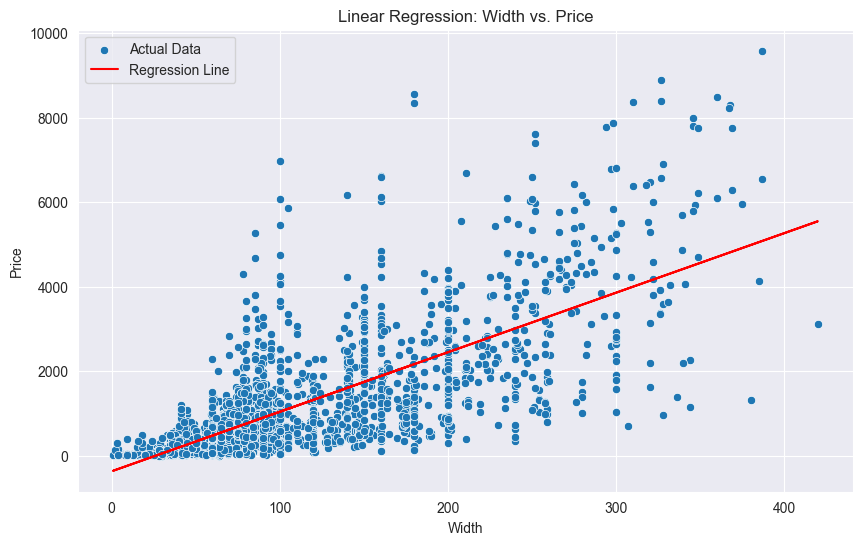

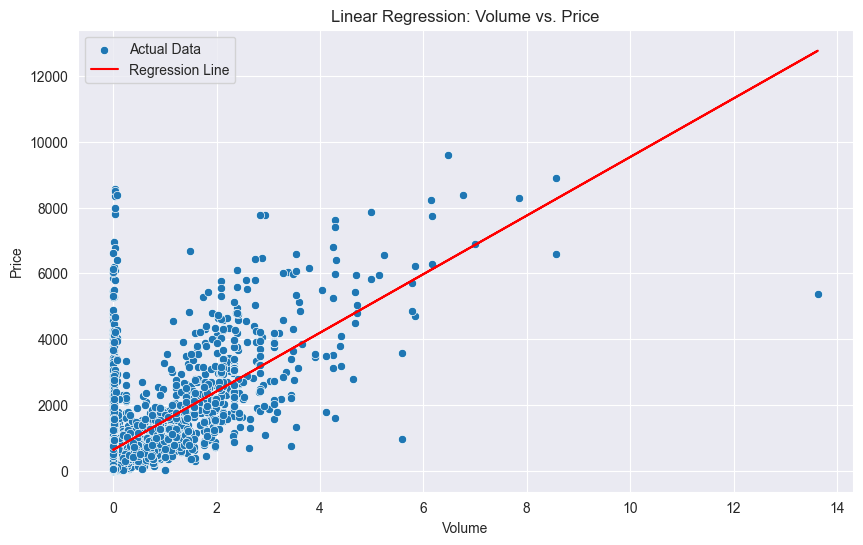

In [74]:
# Візуалізуємо модель лінійної регресії

# Передбачення моделі
predictions = model.predict()
predictions2 = model2.predict()

# Створюємо перший графік
plt.figure(figsize=(10, 6))

# Точковий графік даних
sns.scatterplot(x=X['width'], y=Y, label='Actual Data')

# Лінія лінійної регресії
plt.plot(X['width'], predictions, color='red', label='Regression Line')

# Підписи
plt.title('Linear Regression: Width vs. Price')
plt.xlabel('Width')
plt.ylabel('Price')
plt.legend()
plt.show()

# Створюємо другий графік
plt.figure(figsize=(10, 6))

# Точковий графік даних
sns.scatterplot(x=X2['volume'], y=Y2, label='Actual Data')

# Лінія лінійної регресії
plt.plot(X2['volume'], predictions2, color='red', label='Regression Line')

# Підписи
plt.title('Linear Regression: Volume vs. Price')
plt.xlabel('Volume')
plt.ylabel('Price')
plt.legend()
plt.show()

> Проаналізувавши залежність ціни від об'єму та ширини товару, в обох випадках p-value було близьке до 0, а отже можна відкинути гіпотезу Н0 та прийняти альтернативну. Крім того, в обох випадках коефіцієнти лінійної регресії показали, що зі збільшенням розміру збільшується ціна, для ширини це: ціна = -368.5 + 14*Х(ширини), для об'єму це: ціна = 638.2 + 889.9*Х(об'єму). Проте коефіцієнти детермінації становили: 0.52 для ширини, та 0.39 для об'єму, що свідчить про те, що задовільною моделлю можна вважати лише залежність ціни від ширини. Параметри висоти та довжини не аналізувалися, оскільки коефіцієнт кореляції не був значний, та наявністю великої кількості пустих значень, що робить аналіз менш репрезентативным.

### Machine learning

In [75]:
df_ikea_norm

,name,price,sellable_online,other_colors,depth,height,width,product,designer_normalized,volume
0,FREKVENS,265.0,True,No,NaN,99.0,51.0,Bar table,Nicholai Wiig Hansen,0.005049
1,NORDVIKEN,995.0,False,No,NaN,105.0,80.0,Bar table,Francis Cayouette,0.008400
2,NORDVIKEN / NORDVIKEN,2095.0,False,No,NaN,NaN,NaN,Bar table and 4 bar stools,Francis Cayouette,0.000001
3,STIG,69.0,True,Yes,50.0,100.0,60.0,Bar stool with backrest,Henrik Preutz,0.300000
4,NORBERG,225.0,True,No,60.0,43.0,74.0,Wall-mounted drop-leaf table,Marcus Arvonen,0.190920
...,...,...,...,...,...,...,...,...,...,...
3688,PAX / MEHAMN/AULI,2045.0,True,No,66.0,236.0,200.0,Wardrobe combination,Ehlén Johansson/IKEA of Sweden,3.115200
3689,ELVARLI,750.0,True,No,50.0,NaN,91.0,1 section,Ehlén Johansson,0.004550
3690,ELVARLI,1572.0,True,No,50.0,NaN,135.0,2 sections,Ehlén Johansson,0.006750
3691,ELVARLI,924.0,True,No,50.0,NaN,175.0,2 sections,Ehlén Johansson,0.008750


> Проаналізувавши набір даних, були сформовані та підтверджені гіпотези, щодо впливу фіч на ціну. Відповідно до цього вважається доцільним перевірити цей вплив на якості навчання та прогнозування моделей машинного навчання. Для цього варто сформувати чотири набори даних зі зменшенням кількості фіч в кожному.

In [91]:
# Виокремлюємо фічі та таргет


# Набір даних з виключенням фіч depth, height та width, оскільки фіча volume є похідною від довжини, ширини та висоти
X1 = df_ikea_norm[['name', 'sellable_online', 'other_colors', 'product', 'designer_normalized', 'volume']]
# Набір даних з виключенням фічі volume, оскільки ця фіча є похідною від довжини, ширини та висоти
X2 = df_ikea_norm[['name', 'sellable_online', 'other_colors', 'depth', 'height', 'width', 'product', 'designer_normalized']]
# Набір даних з виключенням фіч sellable_online, depth та height, оскільки фічі depth та height мають багато пропусків та слабку кореляцію, а sellable_online репрезентує менш як 1% набору даних
X3 = df_ikea_norm[['name', 'other_colors', 'width', 'product', 'designer_normalized', 'volume']]
# Набір даних з виключенням фіч sellable_online, volume, depth та height,
X4 = df_ikea_norm[['name', 'other_colors', 'width', 'product', 'designer_normalized']]

features = {'X1':X1, 'X2':X2, 'X3':X3, 'X4':X4}

# Таргет
y = df_ikea_norm['price']

In [92]:
# # Split into training and testing sets
def split_to_train_test(features: dict, y: pd.Series) -> dict:
    res = {}
    for feature_name, features_values in features.items():        
        X_train, X_test, y_train, y_test = train_test_split(features_values, y, test_size = 0.2, random_state=42)
        res[feature_name] = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}
    return res         

In [93]:
# num transformation
numeric_transf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('impute', SimpleImputer(strategy='median'))
])

# cat transformation
categorical_transf = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])



In [94]:
# Make a function to choose best regressor
def best_regressor (features, y):
    # Choose models
    models = [
        sk.linear_model.LinearRegression(n_jobs=-1),
        sk.linear_model.LassoCV(n_jobs=-1),
        sk.linear_model.RidgeCV(),
        sk.neighbors.KNeighborsRegressor(n_neighbors=5, n_jobs=-1),
        sk.tree.DecisionTreeRegressor(max_depth=7, random_state=42),
        RandomForestRegressor(random_state=42, n_jobs=-1),
        GradientBoostingRegressor()
    ]

    TestModels = pd.DataFrame()
    res = {}
    tmp = {}

    for model in models:
        for feature_name, feature_value in split_to_train_test(features, y).items():
            m = str(model)
            tmp['Model'] = m[:m.index('(')] +' (' + feature_name + ')'
            # Apply ColumnTransformer to feature columns
            col_prepr = ColumnTransformer(transformers=[
                ('numeric', numeric_transf, feature_value.get('X_train').select_dtypes(include='float64').columns), # Підставляємо колонки для трансформації в залежності від тих які є в df
                ('categorical', categorical_transf, feature_value.get('X_train').select_dtypes(include='object').columns)
            ])
            model_pipeline = Pipeline(steps=[
                ('preprocessor', col_prepr),  # Data preprocessing step
                ('classifier', model)
            ])
            model_pipeline.fit(feature_value.get('X_train'), feature_value.get('y_train'))
            tmp['R^2'] = '{:.5f}'.format(model_pipeline.score(feature_value.get('X_test'), feature_value.get('y_test')))
            tmp['MAE'] = '{:.5f}'.format(sk.metrics.mean_absolute_error(model_pipeline.predict(feature_value.get('X_test')), feature_value.get('y_test')))
            tmp['RMSE'] = '{:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(model_pipeline.predict(feature_value.get('X_test')), feature_value.get('y_test'))))

            TestModels = pd.concat([TestModels, pd.DataFrame([tmp])])

    TestModels.set_index('Model', inplace=True)
    res['model'] = TestModels

    return res        
        

In [96]:
# Run tests
test_regressor = best_regressor(features, y)
test_regressor['model'].sort_values(by='R^2', ascending=False)

,R^2,MAE,RMSE
Model,,,
RandomForestRegressor (X2),0.86795,293.86751,498.70618
RandomForestRegressor (X3),0.84927,306.91040,532.82660
RidgeCV (X2),0.84678,341.81153,537.21212
RidgeCV (X3),0.84262,342.17981,544.45024
LinearRegression (X2),0.84141,342.77202,546.54215
LinearRegression (X3),0.83942,344.02995,549.96335
RidgeCV (X4),0.83628,355.55767,555.31060
LinearRegression (X4),0.83114,356.73695,563.96259
RandomForestRegressor (X4),0.82447,331.56161,574.98978


> Модель RandomForestRegressor з наборм фіч ('name', 'sellable_online', 'other_colors', 'depth', 'height', 'width', 'product', 'designer_normalized') показала найкращий результат серед інших

In [83]:
#Застосуємо GridSearchCV для RandomForestRegressor та налаштуємо гіперпараметри

# Трансофрмуємо дані
column_transf = ColumnTransformer(transformers=[
    ('numeric', numeric_transf,  split_to_train_test(features, y).get('X2').get('X_train').select_dtypes(include='float64').columns), # Підставляємо колонки для трансформації в залежності від тих які є в df
    ('categorical', categorical_transf, split_to_train_test(features, y).get('X2').get('X_train').select_dtypes(include='object').columns)
])

# Налаштовуємо тюнінг для RandomForestRegressor
rfr_grid = Pipeline(steps=[
    ('preprocessor', column_transf),
    ('grid_search', GridSearchCV(RandomForestRegressor(), {'n_estimators': [10,25,50,100,110,120,130, 140,150,200,500],
                                                           'max_depth': [10,20,30,40,50,100,200],
                                                           'max_features': [8, 5, 'sqrt','log2', None]}, cv=5, n_jobs=-1, verbose=0))
])

# Навчаємо модель
rfr_grid.fit(split_to_train_test(features, y).get('X2').get('X_train'), split_to_train_test(features, y).get('X2').get('y_train'))

# Створюємо зміну, щоб користуватись методами GridSearchCV
grid_search = rfr_grid.named_steps['grid_search']

# Виводимо показники
print('Best Estimator :',grid_search.best_estimator_)
print('Best Score     :',grid_search.best_score_)
print('')
print('R^2            : {:.5f}'.format(sk.metrics.r2_score(split_to_train_test(features, y).get('X2').get('y_test'), rfr_grid.predict(split_to_train_test(features, y).get('X2').get('X_test')))))
print('MAE            : {:.5f}'.format(sk.metrics.mean_absolute_error(rfr_grid.predict(split_to_train_test(features, y).get('X2').get('X_test')), split_to_train_test(features, y).get('X2').get('y_test'))))
print('RMSE           : {:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(rfr_grid.predict(split_to_train_test(features, y).get('X2').get('X_test')), split_to_train_test(features, y).get('X2').get('y_test')))))
print('')
print('Feature importance:')
print('--------------------------------')

# Після застосування OneHotEncoder в моделі велика кількість стовпців, щоб порахувати вплив фіч треба їх згрупувати
# Створюємо array з назвами фіч
numeric_features = split_to_train_test(features, y).get('X2').get('X_train').select_dtypes(include='float64').columns
categorical_features = column_transf.named_transformers_['categorical'].get_feature_names_out(
    split_to_train_test(features, y).get('X2').get('X_train').select_dtypes(include='object').columns)

feature_names = np.concatenate([numeric_features, categorical_features])

# Створюємо словник з назвами фіч та коефіцієнтом важлисвості 
f_importance = {}
for feat, importance in zip(feature_names, grid_search.best_estimator_.feature_importances_):
    f_importance[feat] = importance

# Створюємо датафрейм
feat = pd.DataFrame(f_importance, index= [0])
# Перевертаємо таблицю
feat_df = pd.melt(feat, var_name='feature', value_name='score')
# Фунція для виокремлення назви фічі
def feature_norm(string):
    val = string.split('_')[0]
    return val
# Виокремлюємо назву
feat_df['feature'] = feat_df['feature'].apply(feature_norm)
# Виводимо 'Feature importance'
print(feat_df.groupby('feature').sum())

Best Estimator : RandomForestRegressor(max_depth=200, max_features='sqrt', n_estimators=500)
Best Score     : 0.8366195217761205

R^2            : 0.86367
MAE            : 282.10482
RMSE           : 506.73589

Feature importance:
--------------------------------
             score
feature           
depth     0.106284
designer  0.155933
height    0.065501
name      0.161704
other     0.015253
product   0.294547
width     0.200778


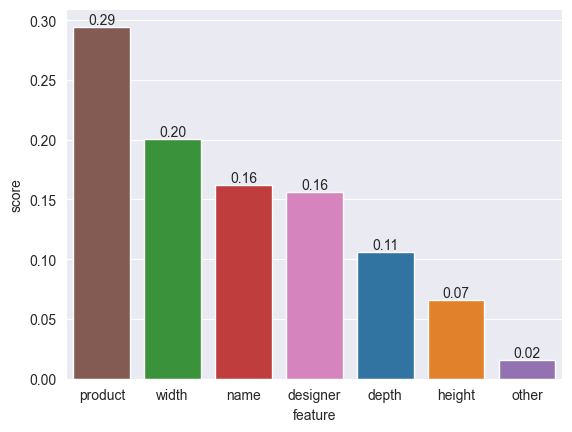

In [84]:
# Візуалізуємо важливість фіч у порядку спадання
sort = feat_df.groupby('feature').sum().sort_values(by='score', ascending=False).reset_index()
ax = sns.barplot(data=feat_df, x='feature', y='score', hue='feature', estimator='sum', errorbar=None, order=sort['feature'])
ax.bar_label(ax.containers[0], fontsize=10, fmt='{:,.2f}');
ax.bar_label(ax.containers[1], fontsize=10, fmt='{:,.2f}');
ax.bar_label(ax.containers[2], fontsize=10, fmt='{:,.2f}');
ax.bar_label(ax.containers[3], fontsize=10, fmt='{:,.2f}');
ax.bar_label(ax.containers[4], fontsize=10, fmt='{:,.2f}');
ax.bar_label(ax.containers[5], fontsize=10, fmt='{:,.2f}');
ax.bar_label(ax.containers[6], fontsize=10, fmt='{:,.2f}');

> Проаналізуваши здатність до передбачення ціни на даному наборі даних, можна зробити висновки, що найкращою моделю виявилася RandomForestRegressor з наборм фіч ('name', 'sellable_online', 'other_colors', 'depth', 'height', 'width', 'product', 'designer_normalized') з параметрами (max_depth=100, max_features='sqrt', n_estimators=500).
> 
> Маючи наступні метрики, можна ствердити, що модель навчилась досить добре, модель сформувала такий набір незалежних змінних, який описує 86% зміни ціни, що є доволі не поганим результатом, також варто відзначити, що середня різниця між прогнозованим і фактичним значенням є нормальною враховуючи те, що середня ціна в наборі даних 1078 і розмах 9500:
> 
>> Best Score     : 0.83
> 
>> R^2            : 0.86
> 
>> MAE            : 283.43
> 
>> RMSE           : 508.56

### Крос-валідація

In [98]:
# Перевіримо, як модель RandomForestRegressor поводиться на різних розбивках даних

model_pipeline = Pipeline(steps=[
    ('preprocessor', column_transf),  
    ('classifier', RandomForestRegressor(max_depth=100, max_features='sqrt', n_estimators=500, n_jobs=-1)),
])

cv_5 = KFold(n_splits= 5, shuffle= True, random_state= 42)
cv_6 = KFold(n_splits= 6, shuffle= True, random_state= 42)
cv_7 = KFold(n_splits= 7, shuffle= True, random_state= 42)
cv_8 = KFold(n_splits= 8, shuffle= True, random_state= 42)
cv_9 = KFold(n_splits= 9, shuffle= True, random_state= 42)

score_5 = cross_val_score(model_pipeline, X2, y, scoring= 'r2', cv = cv_5)
score_6 = cross_val_score(model_pipeline, X2, y, scoring= 'r2', cv = cv_6)
score_7 = cross_val_score(model_pipeline, X2, y, scoring= 'r2', cv = cv_7)
score_8 = cross_val_score(model_pipeline, X2, y, scoring= 'r2', cv = cv_8)
score_9 = cross_val_score(model_pipeline, X2, y, scoring= 'r2', cv = cv_9)

In [102]:
len(score_5)

5

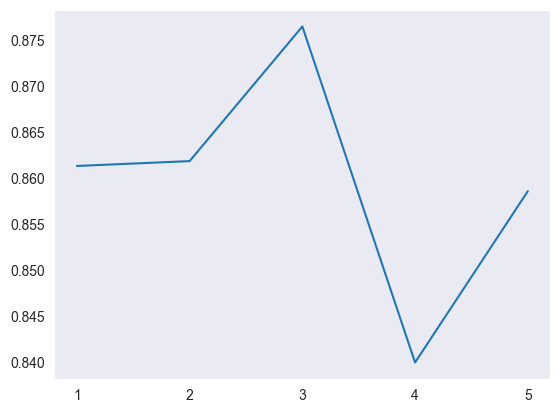

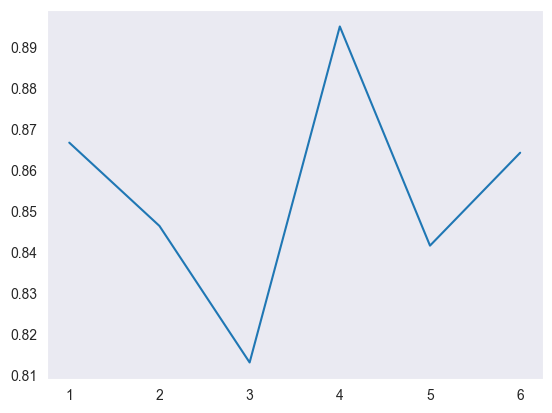

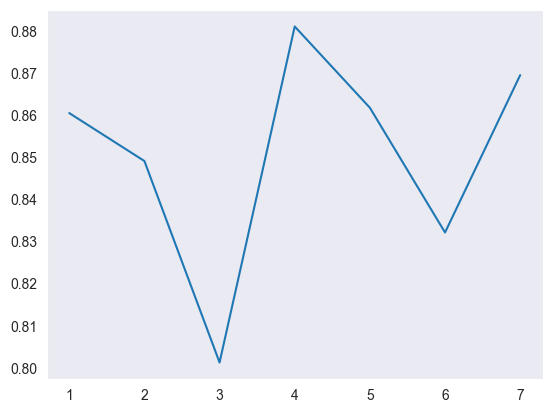

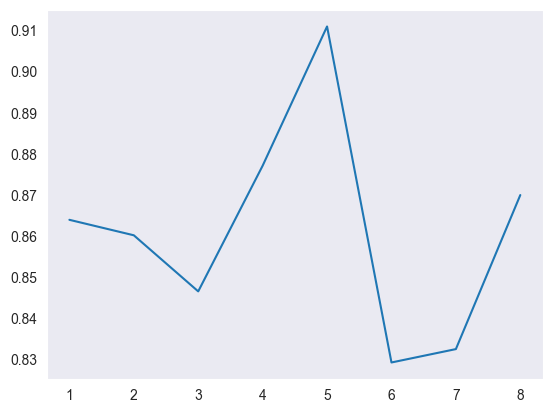

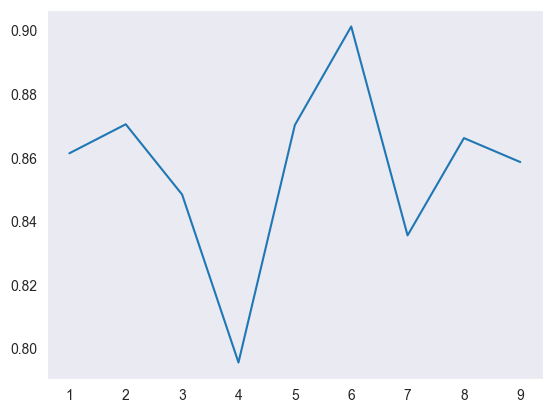

In [104]:
# Візуалізуємо отримані дані

plt.plot(range(1, len(score_5) + 1), score_5);
plt.xticks(range(1, len(score_5) + 1))
plt.grid()
plt.show()

plt.plot(range(1, len(score_6) + 1), score_6);
plt.xticks(range(1, len(score_6) + 1))
plt.grid()
plt.show()

plt.plot(range(1, len(score_7) + 1), score_7);
plt.xticks(range(1, len(score_7) + 1))
plt.grid()
plt.show()

plt.plot(range(1, len(score_8) + 1), score_8);
plt.xticks(range(1, len(score_8) + 1))
plt.grid()
plt.show()

plt.plot(range(1, len(score_9) + 1), score_9);
plt.xticks(range(1, len(score_9) + 1))
plt.grid()
plt.show()

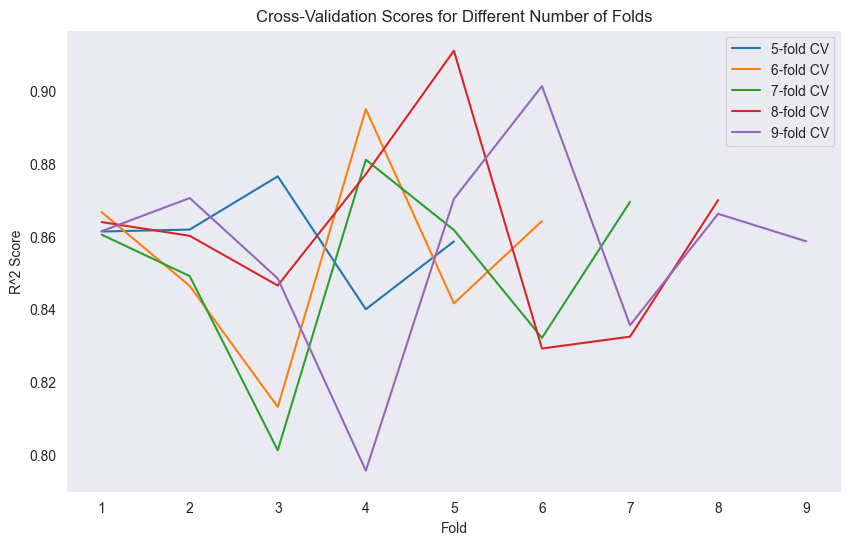

In [99]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(score_5) + 1), score_5, label='5-fold CV')
plt.plot(range(1, len(score_6) + 1), score_6, label='6-fold CV')
plt.plot(range(1, len(score_7) + 1), score_7, label='7-fold CV')
plt.plot(range(1, len(score_8) + 1), score_8, label='8-fold CV')
plt.plot(range(1, len(score_9) + 1), score_9, label='9-fold CV')

plt.xlabel('Fold')
plt.ylabel('R^2 Score')
plt.title('Cross-Validation Scores for Different Number of Folds')
plt.legend()
plt.grid()
plt.show()

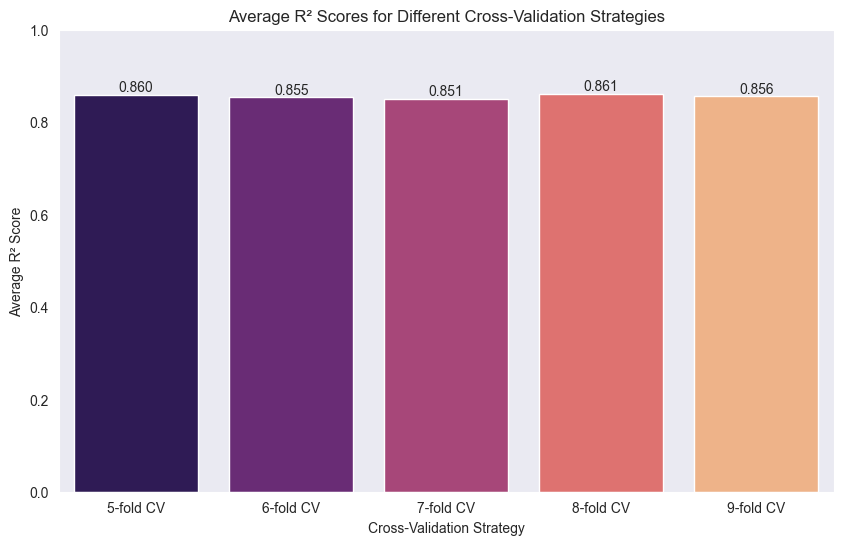

In [115]:
# calculate the average R² score for each strategy
avg_score_5 = np.mean(score_5)
avg_score_6 = np.mean(score_6)
avg_score_7 = np.mean(score_7)
avg_score_8 = np.mean(score_8)
avg_score_9 = np.mean(score_9)

# Prepare data for bar plot
cv_strategies = ['5-fold CV', '6-fold CV', '7-fold CV', '8-fold CV', '9-fold CV']
avg_scores = [avg_score_5, avg_score_6, avg_score_7, avg_score_8, avg_score_9]

# Create bar plot
plt.figure(figsize=(10, 6))
cv = sns.barplot(x = cv_strategies, y = avg_scores, hue= cv_strategies, palette='magma')

plt.xlabel('Cross-Validation Strategy')
plt.ylabel('Average R² Score')
plt.title('Average R² Scores for Different Cross-Validation Strategies')
plt.ylim(0, 1)  # Adjust the y-axis limits based on your data range
plt.grid(axis='y')
cv.bar_label(cv.containers[0], fontsize=10, fmt='{:,.3f}');
cv.bar_label(cv.containers[1], fontsize=10, fmt='{:,.3f}');
cv.bar_label(cv.containers[2], fontsize=10, fmt='{:,.3f}');
cv.bar_label(cv.containers[3], fontsize=10, fmt='{:,.3f}');
cv.bar_label(cv.containers[4], fontsize=10, fmt='{:,.3f}');

plt.show()

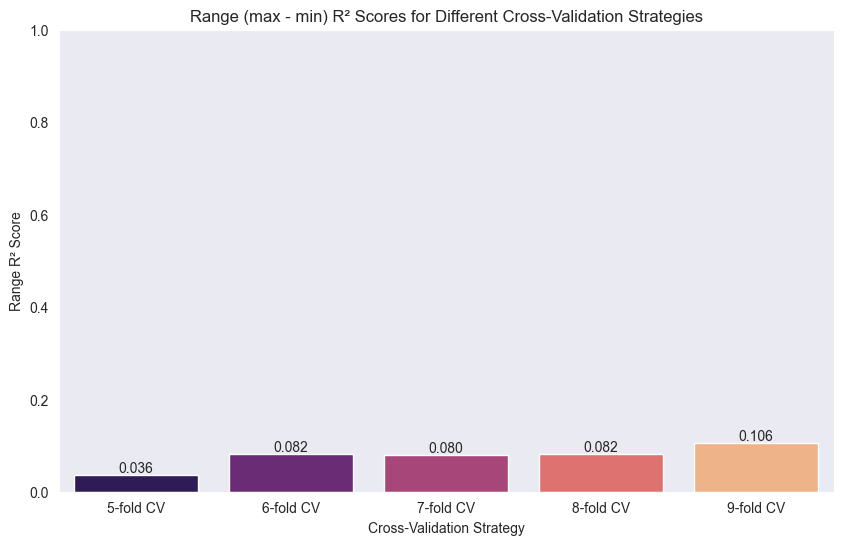

In [118]:
# calculate the range (max - min) R² score for each strategy
range_score_5 = np.max(score_5) - np.min(score_5)
range_score_6 = np.max(score_6) - np.min(score_6)
range_score_7 = np.max(score_7) - np.min(score_7)
range_score_8 = np.max(score_8) - np.min(score_8)
range_score_9 = np.max(score_9) - np.min(score_9)

# Prepare data for bar plot
cv_strategies = ['5-fold CV', '6-fold CV', '7-fold CV', '8-fold CV', '9-fold CV']
range_scores = [range_score_5, range_score_6, range_score_7, range_score_8, range_score_9]

# Create bar plot
plt.figure(figsize=(10, 6))
cv = sns.barplot(x = cv_strategies, y = range_scores, hue= cv_strategies, palette='magma')

plt.xlabel('Cross-Validation Strategy')
plt.ylabel('Range R² Score')
plt.title('Range (max - min) R² Scores for Different Cross-Validation Strategies')
plt.ylim(0, 1)  # Adjust the y-axis limits based on your data range
plt.grid(axis='y')
cv.bar_label(cv.containers[0], fontsize=10, fmt='{:,.3f}');
cv.bar_label(cv.containers[1], fontsize=10, fmt='{:,.3f}');
cv.bar_label(cv.containers[2], fontsize=10, fmt='{:,.3f}');
cv.bar_label(cv.containers[3], fontsize=10, fmt='{:,.3f}');
cv.bar_label(cv.containers[4], fontsize=10, fmt='{:,.3f}');

plt.show()

> Найстабільніший результат модель показує при розбивці на 5 частин коливаючись в діапазоні 0.84 - 0.88, з середнім значенням R2 0.86 та розмахом 0,036